In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import sys
import os
import json

In [2]:
def load_tsp_file(file_path):
    """
    Load TSP (Travelling Salesman Problem) data from a file.

    Parameters:
    - file_path (str): The path to the TSP file.

    Returns:
    - dict: A dictionary containing node numbers as keys and their corresponding
            coordinates as values (NumPy arrays [x, y]).

    The function reads the TSP file, extracts node coordinates, and returns a
    dictionary with node numbers as keys and their coordinates as NumPy arrays.
    It checks for the start of the NODE_COORD_SECTION and stops when it encounters
    the "EOF" line. The function also performs a check to identify any missing nodes
    in the dataset and prints a warning if any are found.
    """

    tsp_data = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Flag to indicate the start of the NODE_COORD_SECTION
    start_loading = False

    for line in lines:
        # Strip leading and trailing whitespaces
        line = line.strip()

        # Check for the start of the NODE_COORD_SECTION
        if line == "NODE_COORD_SECTION":
            start_loading = True
            continue

        # Check for the end of the file
        if line == "EOF":
            break

        if start_loading:
            parts = line.split()
            
            # Extract node number, x-coordinate, and y-coordinate
            node_number = int(parts[0])
            x_coordinate = float(parts[1])
            y_coordinate = float(parts[2])

            # Store data in the dictionary
            tsp_data[node_number] = np.array([x_coordinate, y_coordinate])

    # Check if the dataset is as intuitive as it appears
    nodes = set(tsp_data.keys())
    highest_number = max(nodes)
    missing_nodes = set(range(1, highest_number + 1)) - nodes

    if missing_nodes:
        print(f"Note that not all numbers between 0 and {highest_number} are used as a node ID. Node(s) {missing_nodes} are missing.")

    return tsp_data

In [3]:
def custom_serialize(obj):
    """
    Serialize a Python object for storage or communication.

    This function is designed to return a representation suitable for storing
    or communicating the given object. If the object is a callable (e.g., a function),
    it returns the name of the function. Otherwise, it returns the object itself.

    Parameters:
    - obj: Any Python object to be serialized.

    Returns:
    - str or obj: A serialized representation of the input object. If the object is a
      callable, its name is returned as a string; otherwise, the object is returned as is.
    """
    if callable(obj):
        return obj.__name__
    return obj


def custom_deserialize(obj):
    """
    Deserialize a Python object from stored data.

    This function is designed to reverse the serialization process performed by
    'custom_serialize'. If the input object is a string, it assumes it represents
    the name of a function and returns the corresponding function. Otherwise, it returns
    the input object as is.

    Parameters:
    - obj: Any Python object, potentially serialized using 'custom_serialize'.

    Returns:
    - obj or function: A deserialized representation of the input object. If the input
      object is a string representing the name of a function, the corresponding function
      is returned; otherwise, the input object is returned as is.
    """
    if isinstance(obj, str):
        return globals().get(obj, obj)
    return obj


In [4]:
def generate_solution(tsp_data):
    """
    Generate a random solution as a starting point for the Travelling Salesman Problem (TSP).

    This function creates a random permutation of the city indices provided in the
    tsp_data dictionary, forming an initial solution for the TSP.

    Parameters:
    - tsp_data (dict): A dictionary where keys are integers representing cities,
      and values may contain additional information about the cities.

    Returns:
    - numpy.ndarray: A random permutation of city indices, representing the order
      in which cities are visited in the initial solution for the TSP.
    """
    return np.random.permutation(list(tsp_data.keys()))


def generate_greedy_solution(tsp_data, distance_matrix):
    """
    Generate a greedy solution for the Travelling Salesman Problem (TSP).

    This function constructs a greedy solution for the TSP, starting from the first city
    and iteratively selecting the nearest unvisited neighbor until all cities are visited.

    Parameters:
    - tsp_data (dict): A dictionary where keys are integers representing cities,
      and values may contain additional information about the cities.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances
      between cities. The matrix should be symmetric, and `distance_matrix[i, j]`
      should represent the distance from city `i` to city `j`.

    Returns:
    - numpy.ndarray: A greedy solution for the TSP, represented as an array of city indices.
    """

    route = []
    
    current_city = list(tsp_data.keys())[0]
    route.append(current_city)
    
    # Create a mask to keep track of visited cities
    visited_mask = np.zeros(len(tsp_data), dtype=bool)
    visited_mask[current_city - 1] = True
    
    # Continue searching for the next neighbor until all cities are visited
    while len(route) < len(tsp_data):
        current_index = current_city - 1
        
        # Get the row of distances for the current city
        distances = distance_matrix[current_index]
        
        # Apply the visited mask to exclude already visited cities
        distances[visited_mask] = np.inf
        
        # Find the unvisited neighbor with the minimum distance
        next_city = np.argmin(distances) + 1
        route.append(next_city)
        
        # Mark the next city as visited
        visited_mask[next_city - 1] = True
        
        # Move to the next city
        current_city = next_city
    
    return np.array(route)

In [5]:
def calculate_distance_matrix(tsp_data):
    """
    Calculate the distance matrix based on the coordinates of cities in the Travelling Salesman Problem (TSP).

    This function computes the Euclidean distance between all pairs of cities using their coordinates.

    Parameters:
    - tsp_data (dict): A dictionary where keys are integers representing cities,
      and values are 1D numpy arrays representing the coordinates of the cities.

    Returns:
    - numpy.ndarray: A 2D numpy array representing the distance matrix between cities.
      The element at position (i, j) in the matrix contains the Euclidean distance from
      city with index i to city with index j.
    """

    coordinates = np.array(list(tsp_data.values()))
    distance_matrix = np.linalg.norm(coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :], axis=-1)
    
    return distance_matrix

In [6]:
def get_score(distance_matrix, solution):
    """
    Calculate the total distance of a solution including the round-trip distance
    using a precomputed distance matrix.

    This function computes the total distance of a given solution for a
    Travelling Salesman Problem (TSP) using a precomputed distance matrix.
    The round-trip distance is included by connecting the last city back to the
    first city in the solution.

    Parameters:
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances
      between cities. The matrix should be symmetric, and `distance_matrix[i, j]`
      should represent the distance from city `i` to city `j`.
    - solution (numpy.ndarray): An array representing the order in which cities
      are visited. The values in the array should correspond to the indices of
      cities in the distance matrix.

    Returns:
    - float: The total distance of the solution, including the round-trip distance.
    """
  
    # Convert city indices to array indices
    from_cities = np.array(solution[:-1]) - 1
    to_cities = np.array(solution[1:]) - 1

    # Calculate total distance using the distance matrix
    total_distance = np.sum(distance_matrix[from_cities, to_cities])

    # Add the round-trip distance from the last city back to the first city
    total_distance += distance_matrix[to_cities[-1], to_cities[0]]

    return total_distance

In [7]:
def swap(solution, iteration):
    """
    Perform a swap mutation on a given TSP solution.

    Randomly choose two distinct indices in the solution array and swap the elements at those indices.

    Parameters:
    - solution (numpy.ndarray): An array representing the order in which cities are visited.
    - iteration (int): The current iteration of the mutation algorithm (unused in this function).

    Returns:
    - numpy.ndarray: A new solution obtained by swapping two distinct elements in the original solution.
    """

    # Select 2 random indices
    indices = np.random.choice(len(solution), size=2, replace=False)

    new_solution = solution.copy()

    # Swap the elements at the selected indices
    new_solution[indices[0]], new_solution[indices[1]] = new_solution[indices[1]], new_solution[indices[0]]

    return new_solution


def inversion(solution, iteration):
    """
    Perform an inversion mutation on a given TSP solution.

    Choose two distinct indices for the inversion, then invert the order of elements between those indices.

    Parameters:
    - solution (numpy.ndarray): An array representing the order in which cities are visited.
    - iteration (int): The current iteration of the mutation algorithm (unused in this function).

    Returns:
    - numpy.ndarray: A new solution obtained by inverting the order of elements between two distinct indices in the original solution.
    """
    n = len(solution)

    # Choose two distinct indices for the inversion
    start, end = np.random.choice(n, size=2, replace=False)
    start, end = min(start, end), max(start, end)

    # Perform inversion
    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    return new_solution


def insert(solution, iteration):
    """
    Perform an insertion mutation on a given TSP solution.

    Choose two distinct indices for the insertion and move an element from the source index to the destination index.

    Parameters:
    - solution (numpy.ndarray): An array representing the order in which cities are visited.
    - iteration (int): The current iteration of the mutation algorithm (unused in this function).

    Returns:
    - numpy.ndarray: A new solution obtained by moving an element from a source index to a destination index in the original solution.
    """

    n = len(solution)

    # Choose two distinct indices for the insertion
    source_index, dest_index = np.random.choice(n, size=2, replace=False)

    # Ensure source_index is before dest_index
    source_index, dest_index = min(source_index, dest_index), max(source_index, dest_index)

    # Perform insertion
    moved_element = solution[source_index]
    new_solution = np.delete(solution, source_index)
    new_solution = np.insert(new_solution, dest_index, moved_element)

    return new_solution


def two_opt(solution, iteration):
    """
    Perform a two-opt mutation on a given TSP solution.

    Switch the next possible pair of nodes in the solution.

    Parameters:
    - solution (numpy.ndarray): An array representing the order in which cities are visited.
    - iteration (int): The current iteration of the mutation algorithm.

    Returns:
    - numpy.ndarray: A new solution obtained by switching the order of nodes between two distinct indices in the original solution.
    """

    n = len(solution)

    # Get the number of total pairs
    total_pairs = int(n * (n-1) / 2)

    # Get index of current pair of nodes to consider
    start =  (iteration % total_pairs) // (n-1)
    end =  (iteration % total_pairs) % (n-1)

    start, end = min(start, end), max(start, end)

    new_solution = solution.copy()
    new_solution[start:end + 1] = np.flip(new_solution[start:end + 1])

    return new_solution

In [8]:
def hillclimber(current_score, new_score, T):
    """
    Hillclimber function that accepts only better scores.

    This function determines whether to accept a new score based on the Metropolis criterion,
    which, in this case, only accepts scores that are better than the current score.

    Parameters:
    - current_score (float): The current score or objective function value.
    - new_score (float): The score or objective function value of the proposed new solution.
    - T (float): The temperature parameter (not used in this function).

    Returns:
    - bool: True if the new score is better; False otherwise.
    """

    return current_score > new_score

def simulated_annealing(current_score, new_score, T):
    """
    Simulated annealing acceptance function for optimization algorithms.

    This function determines whether to accept a new score based on the Metropolis criterion,
    which accepts worse scores probabilistically, depending on the temperature parameter T.

    Parameters:
    - current_score (float): The current score or objective function value.
    - new_score (float): The score or objective function value of the proposed new solution.
    - T (float): The temperature parameter controlling the probability of accepting worse solutions.

    Returns:
    - bool: True if the new score is accepted (either better or probabilistically worse); False otherwise.
    """

    return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)

In [9]:
def logarithmic_cool(iterations, cooling_parameters):
    """
    Logarithmic cooling schedule for simulated annealing.

    This function generates a sequence of temperatures based on a logarithmic cooling schedule.

    Parameters:
    - iterations (int): The total number of iterations.
    - cooling_parameters (dict): A dictionary containing the cooling parameters.
      - 'c' (float): A constant factor.

    Returns:
    - numpy.ndarray: An array of temperatures based on the logarithmic cooling schedule.
    """
    i = np.arange(iterations) + 1
    return cooling_parameters['c'] / np.log(1 + i)


def linear_cool(iterations, cooling_parameters):
    """
    Linear cooling schedule for simulated annealing.

    This function generates a sequence of temperatures based on a linear cooling schedule.

    Parameters:
    - iterations (int): The total number of iterations.
    - cooling_parameters (dict): A dictionary containing the cooling parameters.
      - 'initial' (float): The initial temperature.
      - 'slope' (float): The slope of the linear cooling.

    Returns:
    - numpy.ndarray: An array of temperatures based on the linear cooling schedule.
    """
    i = np.arange(iterations)
    Ts = cooling_parameters['initial'] - cooling_parameters['slope'] * i
    return np.where(Ts < 0, 0, Ts)


def arithmetic_geometric_cool(iterations, cooling_parameters):
    """
    Arithmetic-geometric cooling schedule for simulated annealing.

    This function generates a sequence of temperatures based on an arithmetic-geometric cooling schedule.

    Parameters:
    - iterations (int): The total number of iterations.
    - cooling_parameters (dict): A dictionary containing the cooling parameters.
      - 'initial' (float): The initial temperature.
      - 'alpha' (float): The alpha parameter.
      - 'beta' (float): The beta parameter.

    Returns:
    - numpy.ndarray: An array of temperatures based on the arithmetic-geometric cooling schedule.
    """
    T = cooling_parameters['initial']
    Ts = np.zeros(iterations)

    for i in range(iterations):
        T = T * cooling_parameters['alpha'] + cooling_parameters['beta']
        Ts[i] = T
    
    return Ts


def exponential_cool(iterations, cooling_parameters):
    """
    Exponential cooling schedule for simulated annealing.

    This function generates a sequence of temperatures based on an exponential cooling schedule.

    Parameters:
    - iterations (int): The total number of iterations.
    - cooling_parameters (dict): A dictionary containing the cooling parameters.
      - 'initial' (float): The initial temperature.
      - 'alpha' (float): The alpha parameter.

    Returns:
    - numpy.ndarray: An array of temperatures based on the exponential cooling schedule.
    """
    i = np.arange(iterations)
    return cooling_parameters['initial'] * cooling_parameters['alpha']**i


def quadratic_cool(iterations, cooling_parameters):
    """
    Quadratic cooling schedule for simulated annealing.

    This function generates a sequence of temperatures based on a quadratic cooling schedule.

    Parameters:
    - iterations (int): The total number of iterations.
    - cooling_parameters (dict): A dictionary containing the cooling parameters.
      - 'initial' (float): The initial temperature.
      - 'alpha' (float): The alpha parameter.

    Returns:
    - numpy.ndarray: An array of temperatures based on the quadratic cooling schedule.
    """
    i = np.arange(iterations)
    return cooling_parameters['initial'] / (1 + cooling_parameters['alpha'] * i**2)

In [10]:
def optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule=logarithmic_cool, cooling_parameters={'c':1}, stopping_point=0.05, save_progress=False):
    """
    Optimize a solution for the Traveling Salesman Problem (TSP) using a specified mutation and acceptance strategy.

    Parameters:
    - start_solution (numpy.ndarray): The initial solution for the TSP represented as an array of city indices.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function that generates a new solution based on the current solution and iteration.
    - accept (function): The acceptance function that determines whether to accept a new solution based on scores and temperature.
    - cooling_schedule (function): The cooling schedule function that generates a sequence of temperatures throughout the optimization.
      Default is logarithmic_cool.
    - cooling_parameters (dict): A dictionary containing parameters for the cooling schedule function.
      Default is {'c': 1}.
    - stopping_point (float): A threshold for early stopping. If the number of iterations without improvement exceeds stopping_point * iterations,
      the optimization process is terminated. Default is 0.05.
    - save_progress (bool): If True, save the scores of accepted solutions during the optimization process. Default is False.

    Returns:
    - Tuple[numpy.ndarray, float, dict]: A tuple containing the optimized solution, its corresponding score, and a dictionary of scores if save_progress is True.
    """

    # Copy start solution and calculate score
    solution = start_solution[:]
    current_score = get_score(distance_matrix, solution)

    # Determine temperature at each iteration to be performed
    Ts = cooling_schedule(iterations, cooling_parameters)

    # Keep track of progress
    iterations_without_improvement = 0
    stopping_point *= iterations

    scores = {}

    # Do iterations
    for i in range(iterations):

        # Make new solution via chosen mutation function
        new_solution = mutate(solution, i)
        new_score = get_score(distance_matrix, new_solution)

        # Accept or deny new solution according to chosen acceptance function and corresponding parameters
        if accept(current_score, new_score, Ts[i]):
            solution = new_solution[:]
            current_score = new_score
            iterations_without_improvement = 0

            if save_progress:
                scores[i] = new_score
        
        # If not accepted, keep track of progress and exit if conditions are met
        else:
            iterations_without_improvement += 1
            if iterations_without_improvement == stopping_point:
                return solution, current_score, scores

    return solution, current_score, scores

In [11]:
def tune_logarithmic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    """
    Tune the parameters of logarithmic cooling schedule for simulated annealing using Optuna.

    Parameters:
    - trial (optuna.trial.Trial): Optuna's trial object for parameter optimization.
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - runs (int): The number of runs for each set of parameters.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function used in the optimization.
    - accept (function): The acceptance function used in the optimization.
    - greedy (bool): If True, use a greedy solution as the starting point; otherwise, generate a random solution.

    Returns:
    - float: The average score over the specified number of runs for the tuned parameters.
    """

    # Generate parameters
    c = trial.suggest_float('c', 0.001, 1000)
    result = 0

    # Perform runs
    for run in range(runs):

        # Make initial solution
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        
        # Calculate contribution of current run to average and add to sum
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, logarithmic_cool, {'c': c})[1] / runs
        
    return result


def tune_linear_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    """
    Tune the parameters of linear cooling schedule for simulated annealing using Optuna.

    Parameters:
    - trial (optuna.trial.Trial): Optuna's trial object for parameter optimization.
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - runs (int): The number of runs for each set of parameters.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function used in the optimization.
    - accept (function): The acceptance function used in the optimization.
    - greedy (bool): If True, use a greedy solution as the starting point; otherwise, generate a random solution.

    Returns:
    - float: The average score over the specified number of runs for the tuned parameters.
    """

    # Generate parameters
    initial = trial.suggest_float('initial', 0.01, 10000)
    slope = trial.suggest_float('slope', 0., 10)
    result = 0

    # Perform runs
    for run in range(runs):

        # Make initial solution
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        
        # Calculate contribution of the current run to average and add to sum
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, linear_cool, {'initial': initial, 'slope': slope})[1] / runs

    return result


def tune_arithmetic_geometric_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    """
    Tune the parameters of arithmetic-geometric cooling schedule for simulated annealing using Optuna.

    Parameters:
    - trial (optuna.trial.Trial): Optuna's trial object for parameter optimization.
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - runs (int): The number of runs for each set of parameters.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function used in the optimization.
    - accept (function): The acceptance function used in the optimization.
    - greedy (bool): If True, use a greedy solution as the starting point; otherwise, generate a random solution.

    Returns:
    - float: The average score over the specified number of runs for the tuned parameters.
    """

    # Generate parameters
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    beta = trial.suggest_float('beta', 0., 100)

    result = 0

    # Perform runs
    for run in range(runs):

        # Make initial solution
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        
        # Calculate contribution of the current run to average and add to sum
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, arithmetic_geometric_cool, {'initial': initial, 'alpha': alpha, 'beta': beta})[1] / runs
        
    return result


def tune_exponential_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    """
    Tune the parameters of exponential cooling schedule for simulated annealing using Optuna.

    Parameters:
    - trial (optuna.trial.Trial): Optuna's trial object for parameter optimization.
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - runs (int): The number of runs for each set of parameters.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function used in the optimization.
    - accept (function): The acceptance function used in the optimization.
    - greedy (bool): If True, use a greedy solution as the starting point; otherwise, generate a random solution.

    Returns:
    - float: The average score over the specified number of runs for the tuned parameters.
    """

    # Generate parameters
    initial = trial.suggest_float('initial', 0.001, 1000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0

    # Perform runs
    for run in range(runs):

        # Make initial solution
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        
        # Calculate contribution of the current run to average and add to sum
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, exponential_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result


def tune_quadratic_cool(trial, tsp_data, distance_matrix, runs, iterations, mutate, accept, greedy=True):
    """
    Tune the parameters of quadratic cooling schedule for simulated annealing using Optuna.

    Parameters:
    - trial (optuna.trial.Trial): Optuna's trial object for parameter optimization.
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - runs (int): The number of runs for each set of parameters.
    - iterations (int): The total number of iterations for the optimization.
    - mutate (function): The mutation function used in the optimization.
    - accept (function): The acceptance function used in the optimization.
    - greedy (bool): If True, use a greedy solution as the starting point; otherwise, generate a random solution.

    Returns:
    - float: The average score over the specified number of runs for the tuned parameters.
    """

    # Generate parameters
    initial = trial.suggest_float('initial', 0.001, 10000)
    alpha = trial.suggest_float('alpha', 0., 1)
    result = 0

    # Perform runs
    for run in range(runs):

        # Make initial solution
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)
        
        # Calculate contribution of the current run to average and add to sum
        result += optimize(start_solution, distance_matrix, iterations, mutate, accept, quadratic_cool, {'initial': initial, 'alpha': alpha})[1] / runs
        
    return result

In [12]:
def tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=None, greedy=False):
    """
    Tune parameters of all combinations of provided cooling schedules and mutations for a set number of iterations, and store them as a JSON file.

    Parameters:
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): A 2D numpy array representing the distances between cities.
    - tuning_runs (int): The number of tuning runs for each combination of mutation and cooling schedule.
    - n_trials (int): The number of trials for each parameter tuning.
    - iterations (int): The total number of iterations for the optimization during tuning.
    - mutations (list of functions): List of mutation functions to be tuned.
    - cooling_schedules (list of functions): List of cooling schedule functions to be tuned.
    - file_path (str): If provided, the path to save the tuned parameters as a JSON file.
    - greedy (bool): If True, use a greedy solution as the starting point during tuning; otherwise, generate a random solution.

    Returns:
    - dict: A dictionary containing tuned parameters for each combination of mutation and cooling schedule.
    """

    if file_path:
        if os.path.exists(file_path):
            print(f"Error: The file '{file_path}' already exists. Please choose a different file name.")
            sys.exit(1)
            
    accept = simulated_annealing
    print_status = False

    all_cooling_parameters = {}
    if not print_status:
        optuna.logging.set_verbosity(optuna.logging.WARNING)

    for mutate in mutations:
        cooling_parameters = {}

        for cooling_schedule in cooling_schedules:
            
            cooling_scheme = cooling_schedule.__name__
            study = optuna.create_study()
            study.optimize(lambda trial: globals()['tune_' + cooling_scheme](trial, tsp_data, distance_matrix, tuning_runs, iterations, mutate, accept, greedy=greedy), n_trials=n_trials)
            cooling_parameters[cooling_scheme] = {'cooling_schedule': cooling_schedule, 'cooling_parameters': study.best_params}

        all_cooling_parameters[mutate.__name__] = cooling_parameters
    
    if file_path:
        with open(file_path, 'w') as file:
            json.dump(all_cooling_parameters, file, default=custom_serialize, indent=2)

    return all_cooling_parameters


def global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy, fileID=''):
    """
    Run the tuning function for all files with different amounts of iterations.

    Parameters:
    - files (list of str): List of file names for TSP configurations.
    - iterations_list (list of int): List of different amounts of iterations for the optimization.
    - cooling_schedules (list of functions): List of cooling schedule functions to be tuned.
    - mutations (list of functions): List of mutation functions to be tuned.
    - tuning_runs (int): The number of tuning runs for each combination of mutation and cooling schedule.
    - n_trials (int): The number of trials for each parameter tuning.
    - greedy (bool): If True, use a greedy solution as the starting point during tuning; otherwise, generate a random solution.
    - fileID (str): An optional string to append to the output file names.

    Returns:
    - None: The function saves tuned parameters as JSON files for each combination of file, iterations, mutation, and cooling schedule.
    """
    
    for file in files:
        file_path = f'TSP-Configurations/{file}.tsp.txt'
        tsp_data = load_tsp_file(file_path)
        distance_matrix = calculate_distance_matrix(tsp_data)

        for iterations in iterations_list:
            tune(tsp_data, distance_matrix, tuning_runs, n_trials, iterations, mutations, cooling_schedules, file_path=f'{fileID}best_parameters_{file}_{iterations}_iterations.json', greedy=greedy)

In [13]:
def load_cooling_info(file_path):
    """
    Load cooling information from a JSON file.

    Parameters:
    - file_path (str): The path to the JSON file containing cooling information.

    Returns:
    - dict: A dictionary containing loaded cooling information, with cooling schedule functions restored.
    """
    with open(file_path, 'r') as file:
        data = json.load(file, object_hook=custom_deserialize)

    for item in data.values():
        for subitem in item.values():
            cooling = subitem['cooling_schedule']
            subitem['cooling_schedule'] = globals()[cooling]
    return data

In [15]:
def compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, accept=simulated_annealing, plot_results=True, print_results=True, set_title=False, greedy=True):
    """
    Compare the performance of different combinations of mutation functions and cooling schedules in optimizing a TSP.

    Parameters:
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): Precomputed distance matrix for TSP data.
    - all_cooling_parameters (dict): Dictionary containing cooling parameters for each mutation and cooling schedule combination.
    - N_runs (int): Number of optimization runs for each combination.
    - iterations (int): Number of iterations for each optimization run.
    - mutations (list): List of mutation functions to be compared.
    - cooling_schedules (list): List of cooling schedule functions to be compared.
    - accept (function, optional): Acceptance function for optimization. Defaults to simulated_annealing.
    - plot_results (bool, optional): If True, plot the results. Defaults to True.
    - print_results (bool, optional): If True, print the results. Defaults to True.
    - set_title (bool, optional): If True, include the number of iterations in the plot title. Defaults to False.
    - greedy (bool, optional): If True, use a greedy initial solution. Defaults to True.

    Returns:
    - list: List of dictionaries containing performance results for each cooling schedule.
      Each dictionary includes the cooling schedule name, mutation function name, scores, average score, and standard deviation.

    If plot_results is True, a bar plot comparing the performance of different combinations is displayed.
    If print_results is True, the results are printed to the console.
    """ 
    results = []
    for cooling_schedule in cooling_schedules:
        cooling_results = []
        
        for mutate in mutations:
            scores = []
            parameters = all_cooling_parameters[mutate.__name__][cooling_schedule.__name__]
            for run in range(N_runs):

                if greedy:
                    start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
                else:
                    start_solution = generate_solution(tsp_data)
                    
                score = optimize(start_solution, distance_matrix, iterations, mutate, accept, **parameters)[1]
                scores.append(score)

            cooling_results.append({'mutation function': mutate.__name__,'scores': scores , 'average': np.mean(scores), 'std': np.std(scores)})

        results.append({'cooling schedule': cooling_schedule.__name__, 'data': cooling_results})
    

    if not(print_results or plot_results):
        return results

    bar_width = 0.1
    bar_positions = np.arange(len(mutations))
    mutation_names = [func.__name__ for func in mutations]
    cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']


    for i, result in enumerate(results):
        if print_results:
            print(f"\n\n{cooling_schemes[i]}:\n")
            print("%-40s %-20s" % ("Mutation Function", "Results"))

        if plot_results:
            bar_results = []
            bar_stds = []

        for data in result['data']:
            average = data['average']
            std = data['std']

            if plot_results:
                bar_results.append(average)
                bar_stds.append(std)

            if print_results:
                mutation_function = data['mutation function']
                score_with_std = "%.4f (+/- %.4f)" % (average, std)
                print("%-40s %-15s" % (mutation_function, score_with_std))
        if plot_results:
            plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, label=cooling_schemes[i], align='center')

    if plot_results:
        title_addition = ''
        if set_title:
            title_addition = f' with {iterations} iterations'
        plt.xlabel('Mutation Functions')
        plt.ylabel('Scores')
        plt.title(f'Performance of all algorithm combinations{title_addition}')
        plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
        plt.grid()

        plt.tight_layout()
        plt.show()

    return results


In [16]:
def compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results, greedy=True, fileID=''):
    """
    Compare the performance of different combinations of mutation functions and cooling schedules for multiple iteration settings.

    Parameters:
    - tsp_data (dict): Dictionary containing TSP data.
    - distance_matrix (numpy.ndarray): Precomputed distance matrix for TSP data.
    - file (str): Name of the file containing precomputed cooling parameters.
    - N_runs (int): Number of optimization runs for each combination.
    - iterations_list (list): List of iteration settings to be compared.
    - greedy (bool, optional): If True, use a greedy initial solution. Defaults to True.
    - fileID (str, optional): Additional identifier for the file name. Defaults to an empty string.

    Returns:
    list: A list containing the results of each comparison for different iteration settings.

    This function loads precomputed cooling parameters from a file, compares the performance of different combinations
    of mutation functions and cooling schedules for each iteration setting, and returns a list of results.
    """

    results = []
    for iterations in iterations_list:
        all_cooling_parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')

        mutations = list(all_cooling_parameters.keys())
        cooling_schedules = list(all_cooling_parameters[mutations[0]].keys())
        
        mutations = [globals()[mutation] for mutation in mutations]
        cooling_schedules = [globals()[cooling_schedule] for cooling_schedule in cooling_schedules]

        result = compare_algorithms(tsp_data, distance_matrix, all_cooling_parameters, N_runs, iterations, mutations, cooling_schedules, plot_results=plot_results, print_results=False, set_title=True, greedy=greedy)
        results.append(result)
    
    return results

In [17]:
def investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, cooling_parameters=None, desired_std=-1, greedy=False, stopping_point=0.05):
    if not cooling_parameters:
        try:
            parameters = load_cooling_info(f'{fileID}best_parameters_{file}_{iterations}_iterations.json')
            cooling_parameters = parameters[mutate.__name__][cooling_schedule.__name__]['cooling_parameters']
        except:
            print(f'Tuning has not been done for {cooling_schedule.__name__} in combination with {mutate.__name__} for the {file} dataset with {iterations} iterations.')
            print(f"So, function needs to be called with parameters")
            return
    
    
    file_path = f'TSP-Configurations/{file}.tsp.txt'
    tsp_data = load_tsp_file(file_path)

    distance_matrix = calculate_distance_matrix(tsp_data)

    accept = simulated_annealing

    # Do first run
    if greedy:
        start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
    else:
        start_solution = generate_solution(tsp_data)

    solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

    event_iterations = list(scores.keys())
    new_scores = list(scores.values())

    if not event_iterations:
        progress_results = [np.interp(np.arange(iterations), [0, iterations], [score, score])]
    else:
        progress_results = [np.interp(np.arange(iterations), event_iterations, new_scores)]

    score_results = [score]

    # Do second run
    if N_runs > 1:
        if greedy:
            start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
        else:
            start_solution = generate_solution(tsp_data)

        solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

        event_iterations = list(scores.keys())
        new_scores = list(scores.values())

        if not event_iterations:
            progress_results.append(np.interp(np.arange(iterations), [0, iterations], [score, score]))
        else:
            progress_results.append(np.interp(np.arange(iterations), event_iterations, new_scores))

        score_results.append(score)

        current_run = 2

        # Continue running until stopping criteria are reached
        while (current_run < N_runs and (np.std(score_results) / np.sqrt(current_run) > desired_std)):
            if greedy:
                start_solution = generate_greedy_solution(tsp_data, distance_matrix.copy())
            else:
                start_solution = generate_solution(tsp_data)

            solution, score, scores = optimize(start_solution, distance_matrix, iterations, mutate, accept, cooling_schedule, cooling_parameters, stopping_point=stopping_point, save_progress=True)

            event_iterations = list(scores.keys())
            new_scores = list(scores.values())

            if not event_iterations:
                progress_results.append(np.interp(np.arange(iterations), [0, iterations], [score, score]))
            else:
                progress_results.append(np.interp(np.arange(iterations), event_iterations, new_scores))

            score_results.append(score)
            current_run += 1

        scores = np.mean(progress_results, axis=0)
        
        errors = np.std(progress_results, axis=0)

    scores = np.mean(progress_results, axis=0)

    return scores, errors

Open a file, and tune the parameters for all different algorithm combinations.

Be advised, might take a while!

In [18]:
files = ['eil51', 'a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]
fileID = 'random_'

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 100

# global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=False, fileID=fileID)

Compare results of the global tuning just done

In [19]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=False, fileID=fileID)


C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


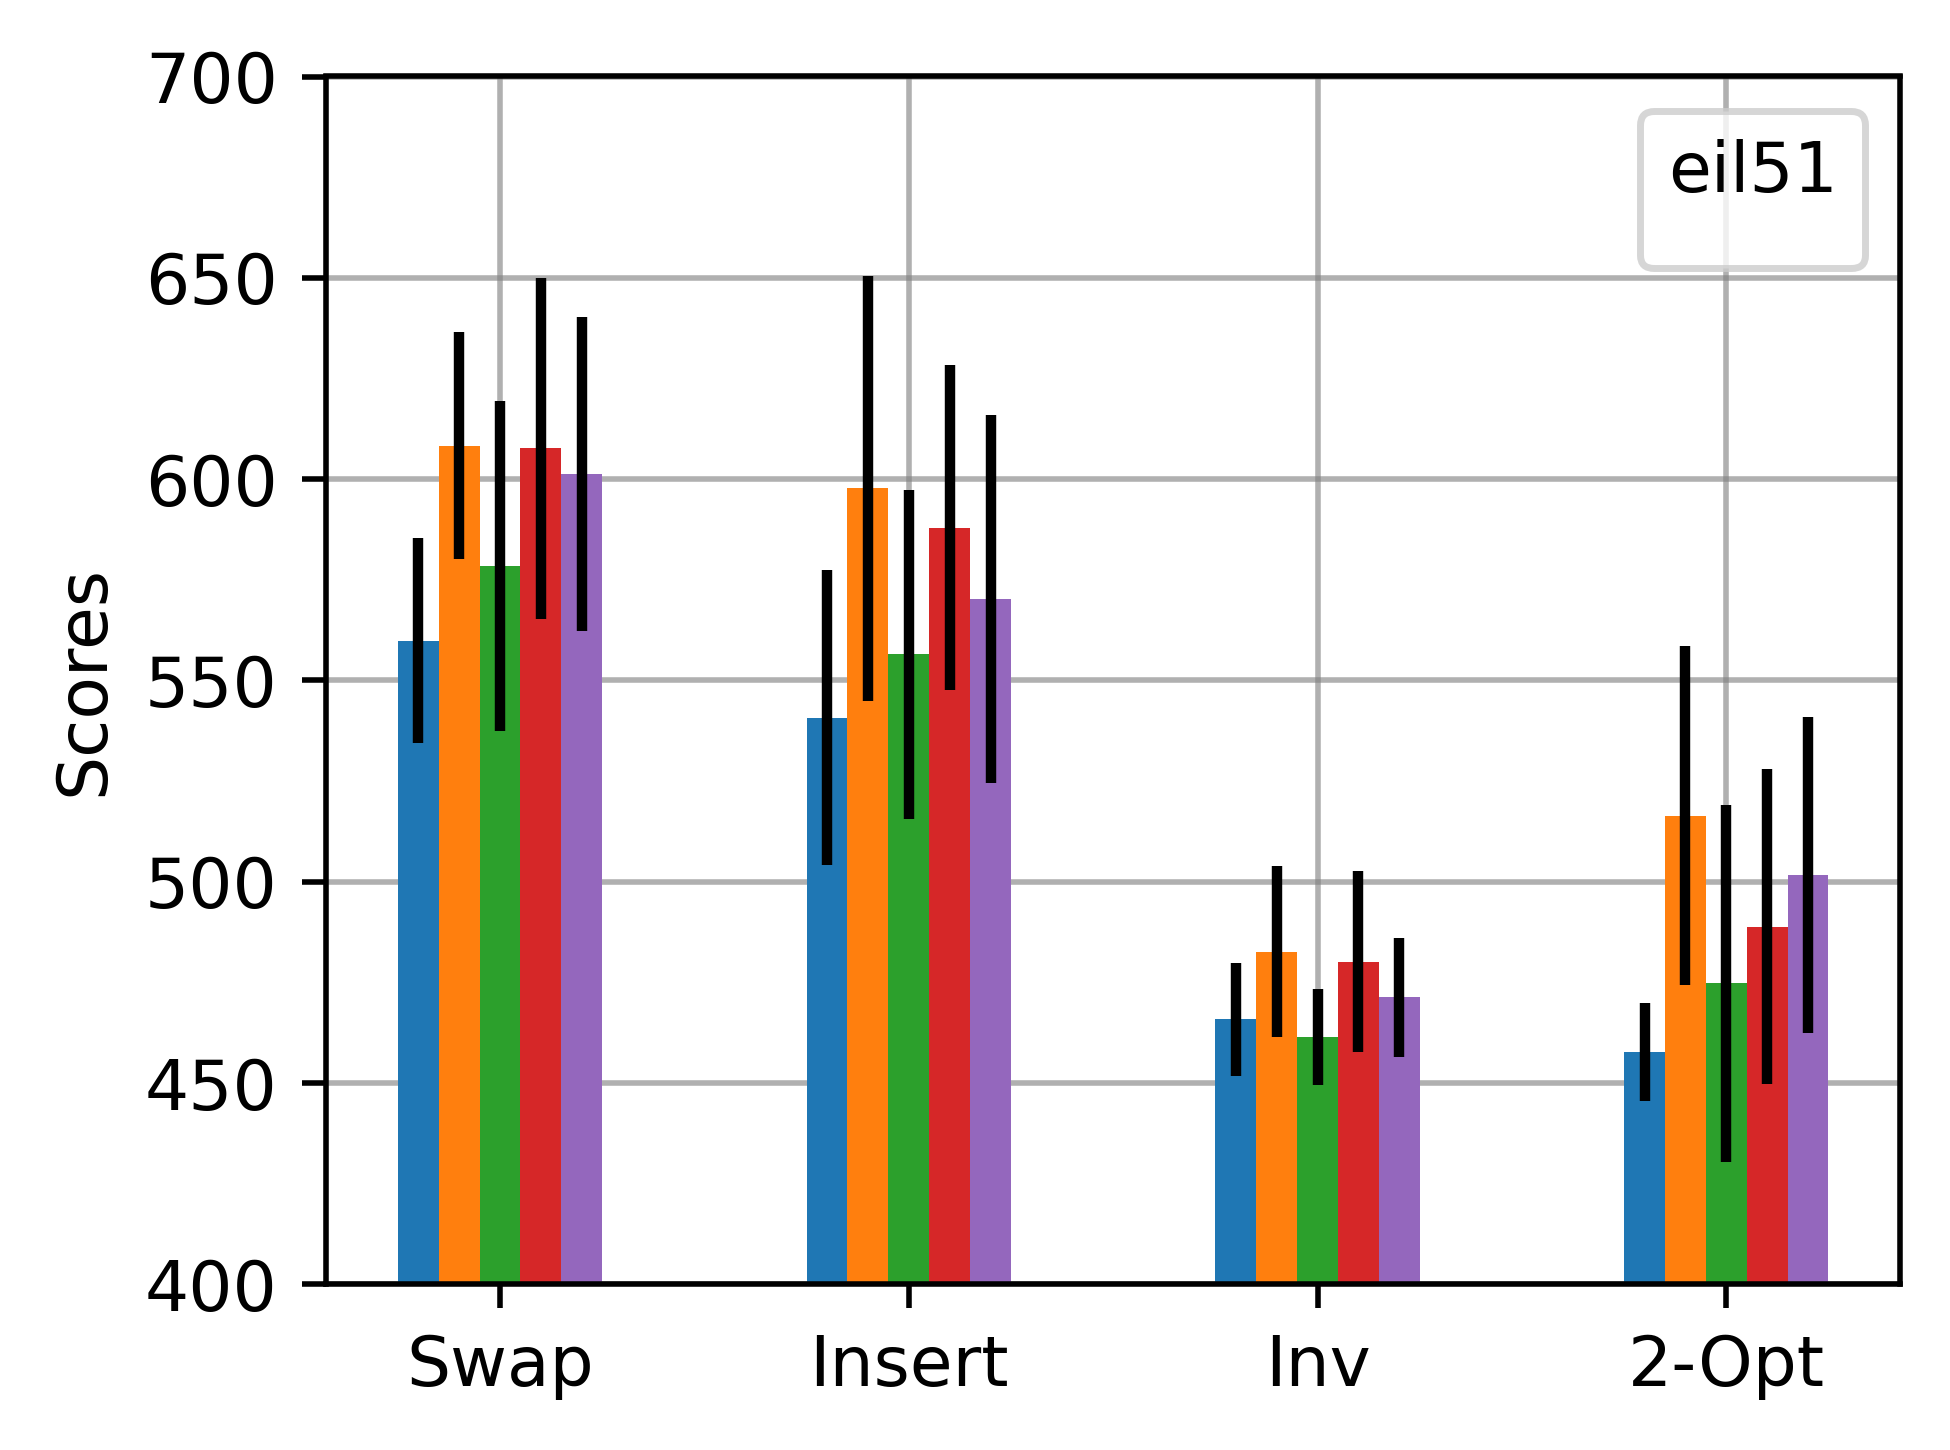

In [20]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2, align='center', alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-',zorder=0,alpha=0.618)
plt.ylim([400, 700])

plt.legend()
plt.legend(title='eil51')

plt.tight_layout()
plt.savefig('tuning_51_random.png')
plt.show()

In [21]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=False, fileID=fileID)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


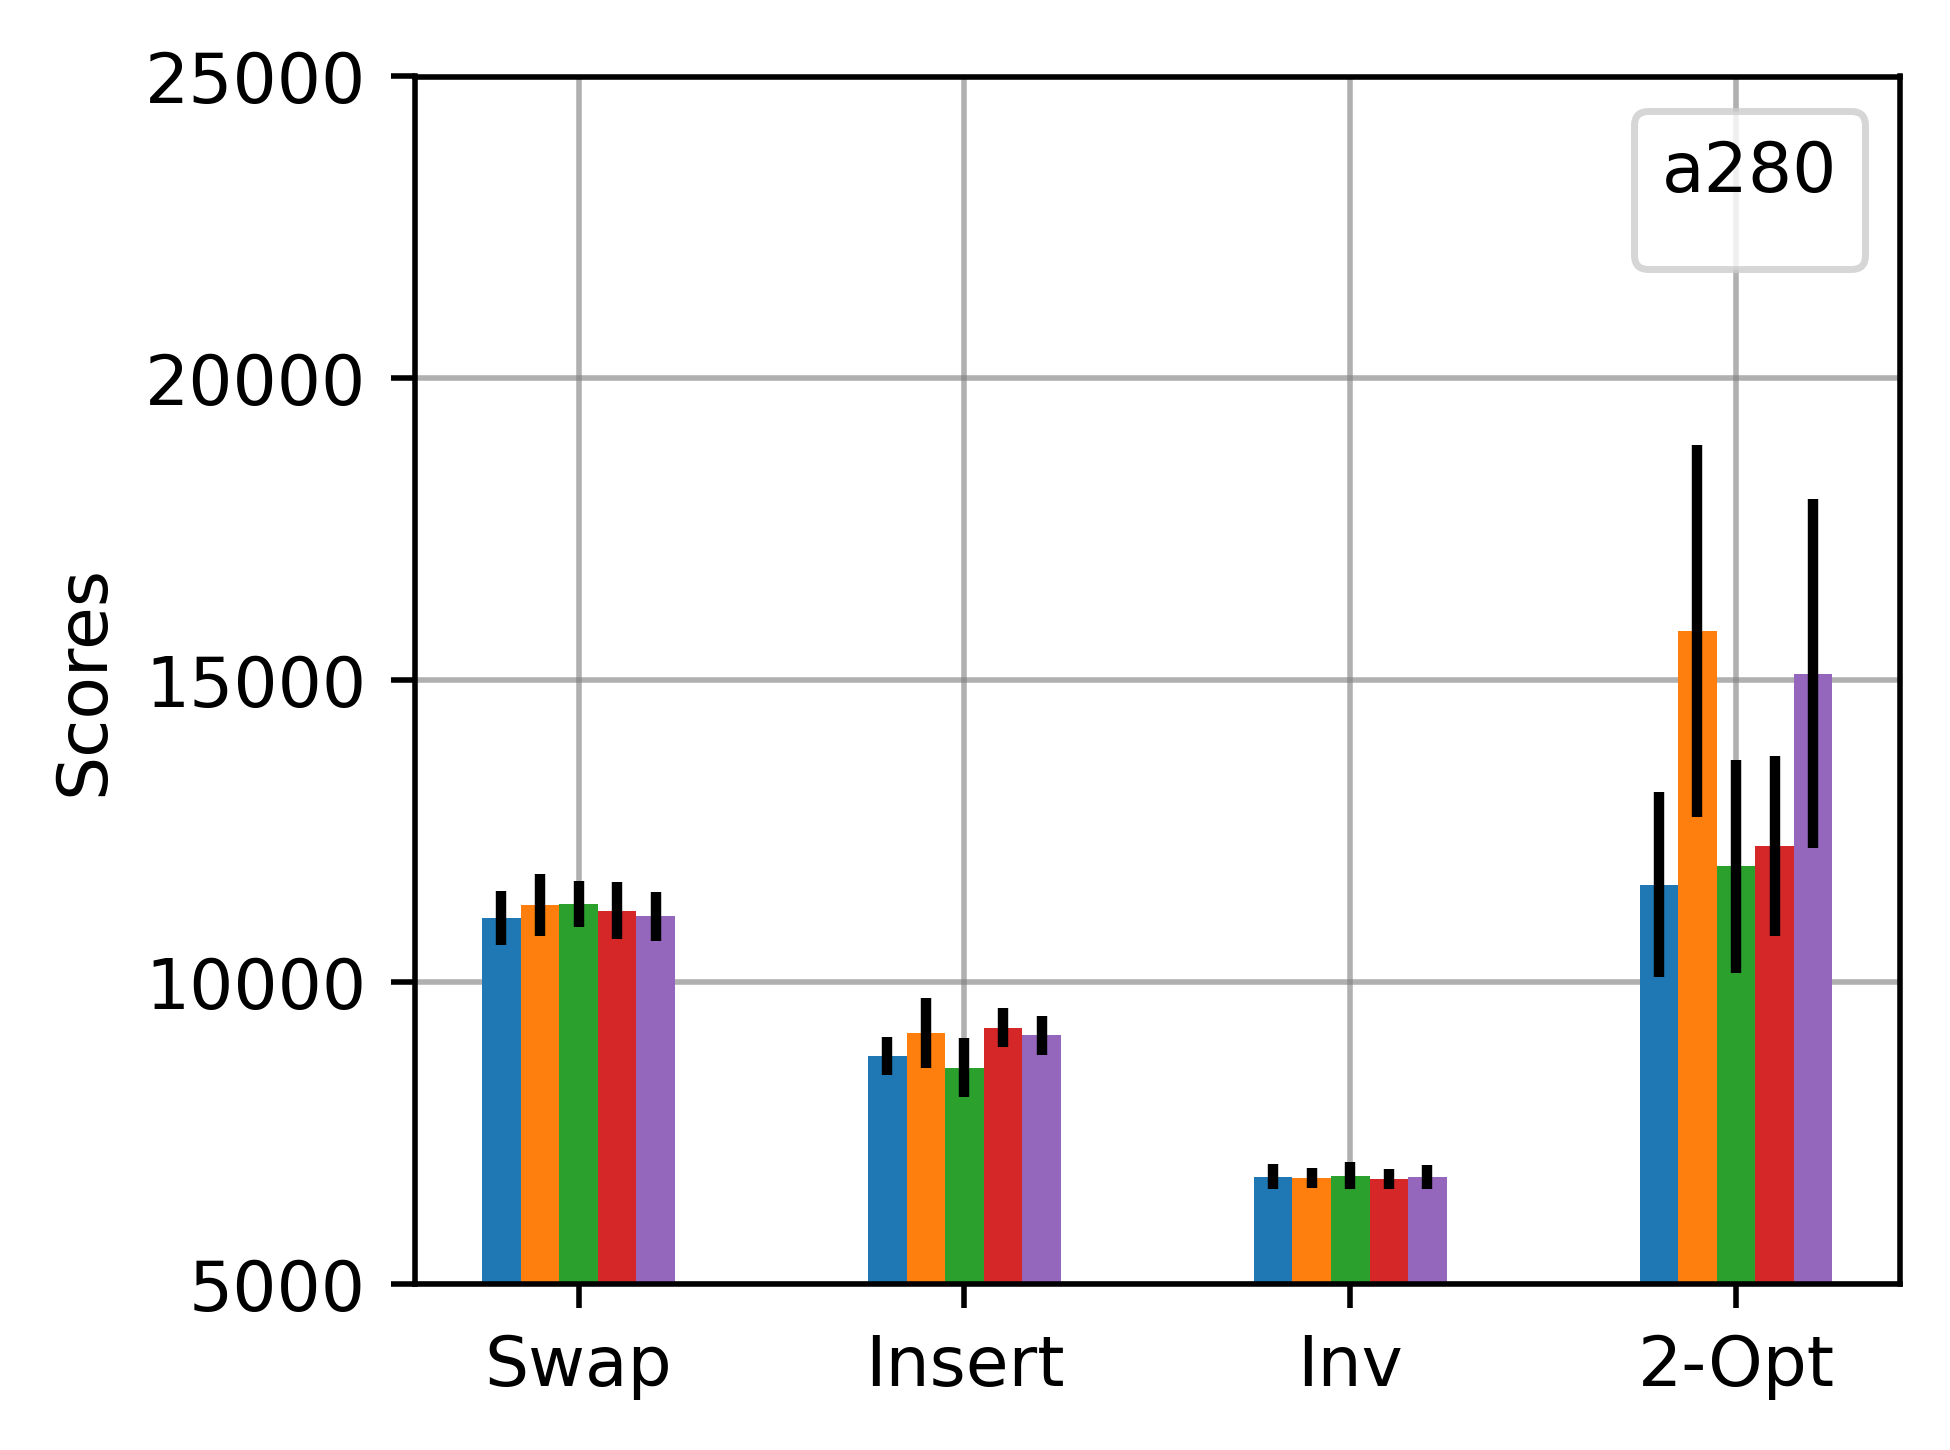

In [22]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2,align='center',alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-', zorder=0, alpha=0.618)
plt.yticks(np.linspace(5000, 25000, 5))
plt.ylim([5000, 25000])

plt.legend(title='a280', loc='upper right')

plt.tight_layout()
plt.savefig('tuning_280_random.png')
plt.show()

In [23]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=False, fileID=fileID)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


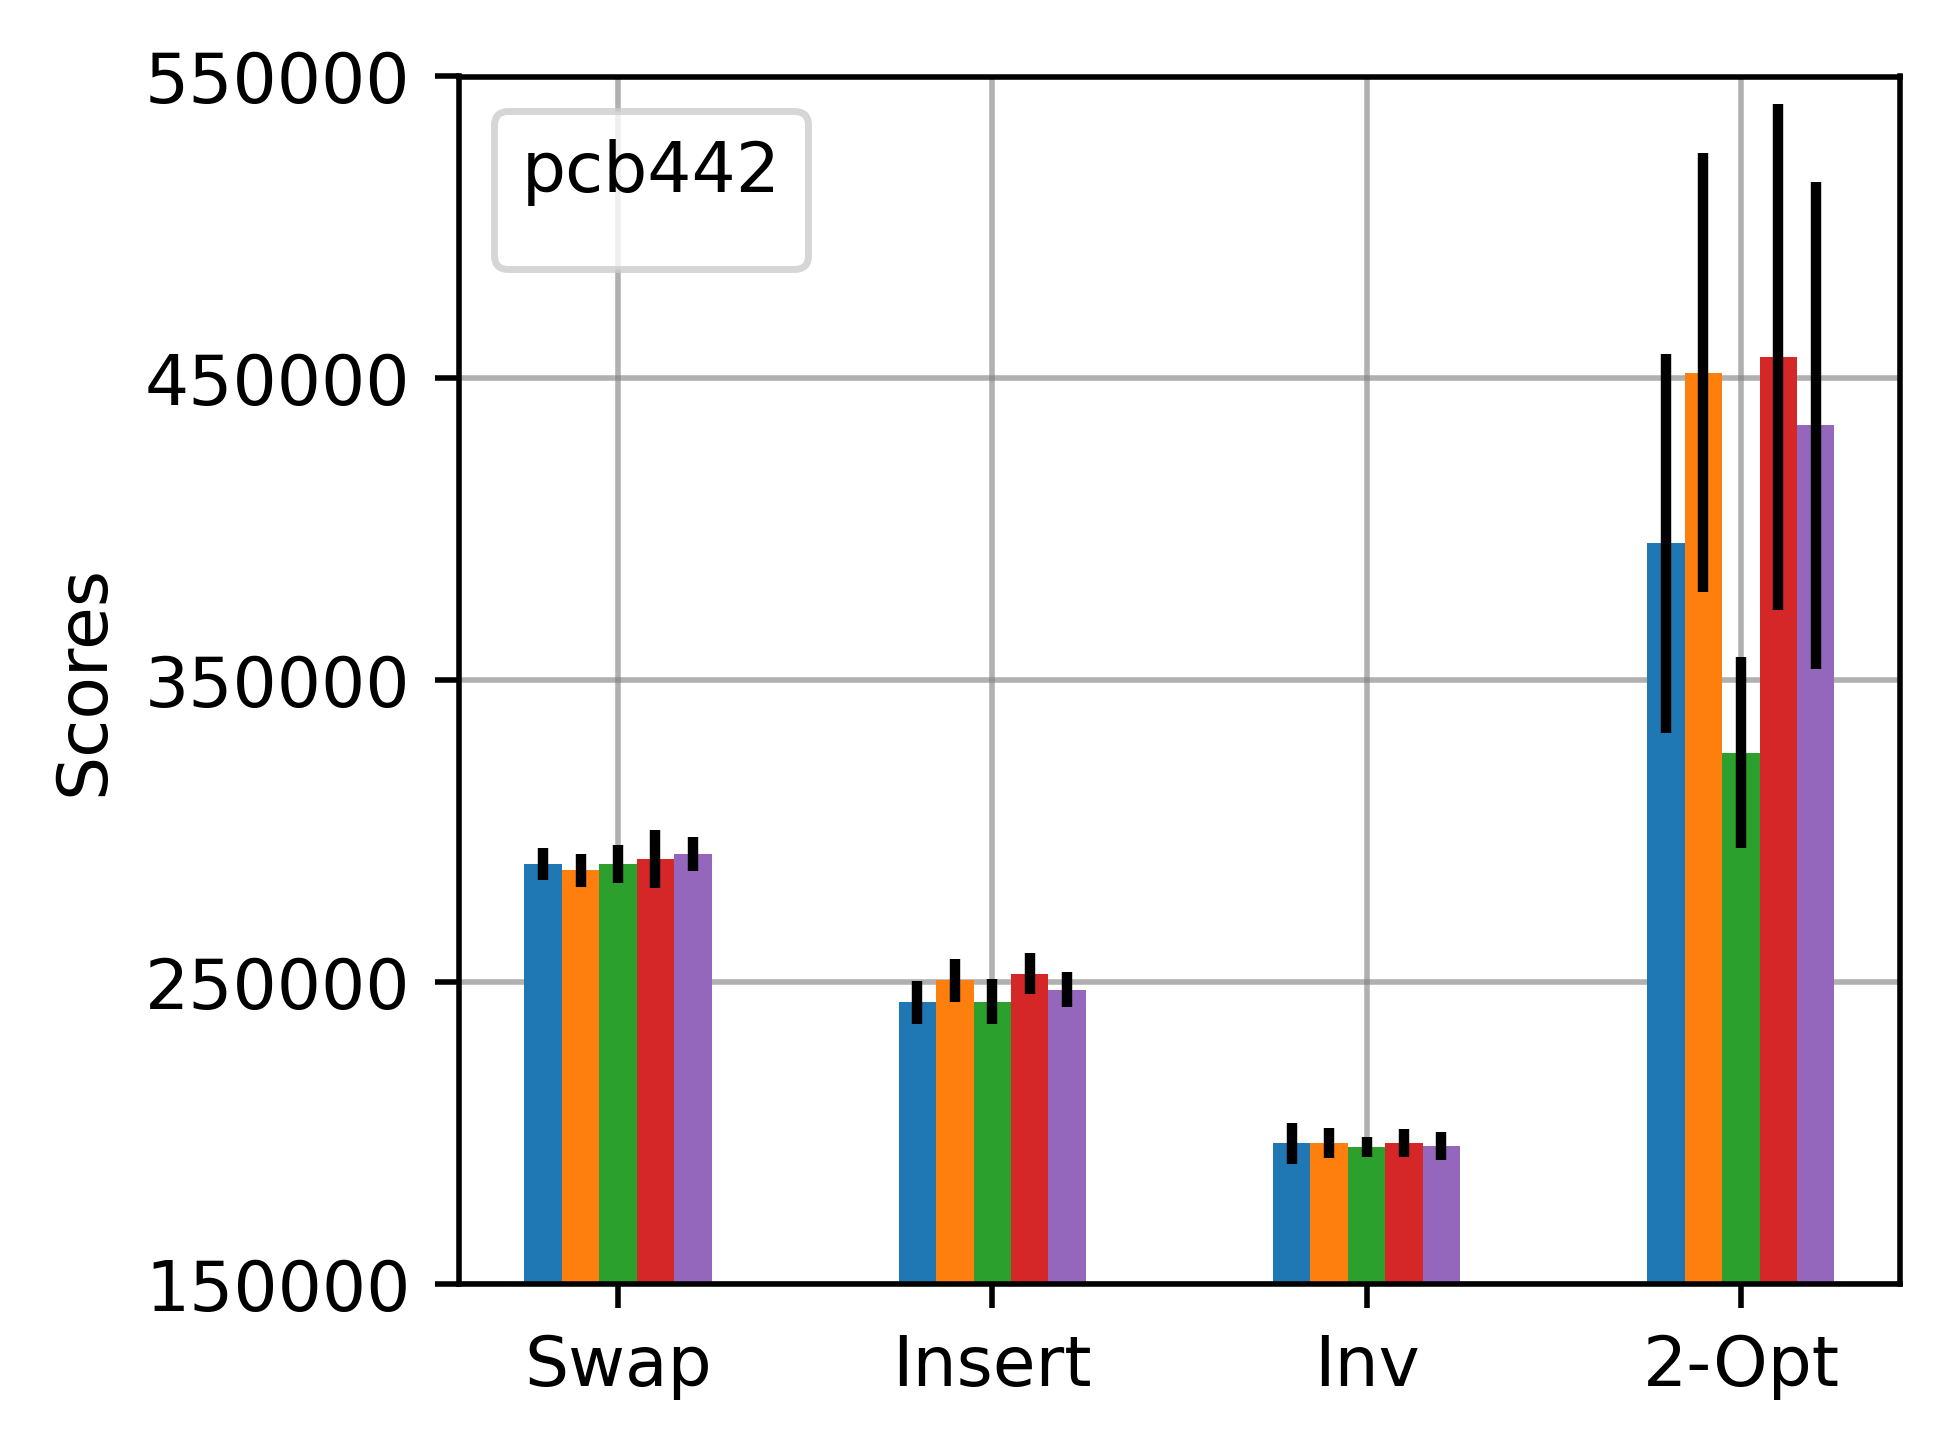

In [24]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2, align='center', alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-', zorder=0, alpha=0.618)
plt.yticks(np.linspace(150000, 550000, 5))
plt.ylim([150000, 550000])

plt.legend(title='pcb442', loc='upper left')

plt.tight_layout()
plt.savefig('tuning_442_random.png')
plt.show()

Do global tuning again, but for a greedy starting solution

In [25]:
files = ['a280', 'pcb442']
cooling_schedules = [logarithmic_cool, linear_cool, arithmetic_geometric_cool, exponential_cool, quadratic_cool]
mutations = [swap, insert, inversion, two_opt]
fileID = 'greedy_'

iterations_list = [5000, 10000]
tuning_runs = 5
n_trials = 50

# global_tuning(files, iterations_list, cooling_schedules, mutations, tuning_runs, n_trials, greedy=True, fileID=fileID)

In [26]:
N_runs = 20
file = 'eil51'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=True, fileID=fileID)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


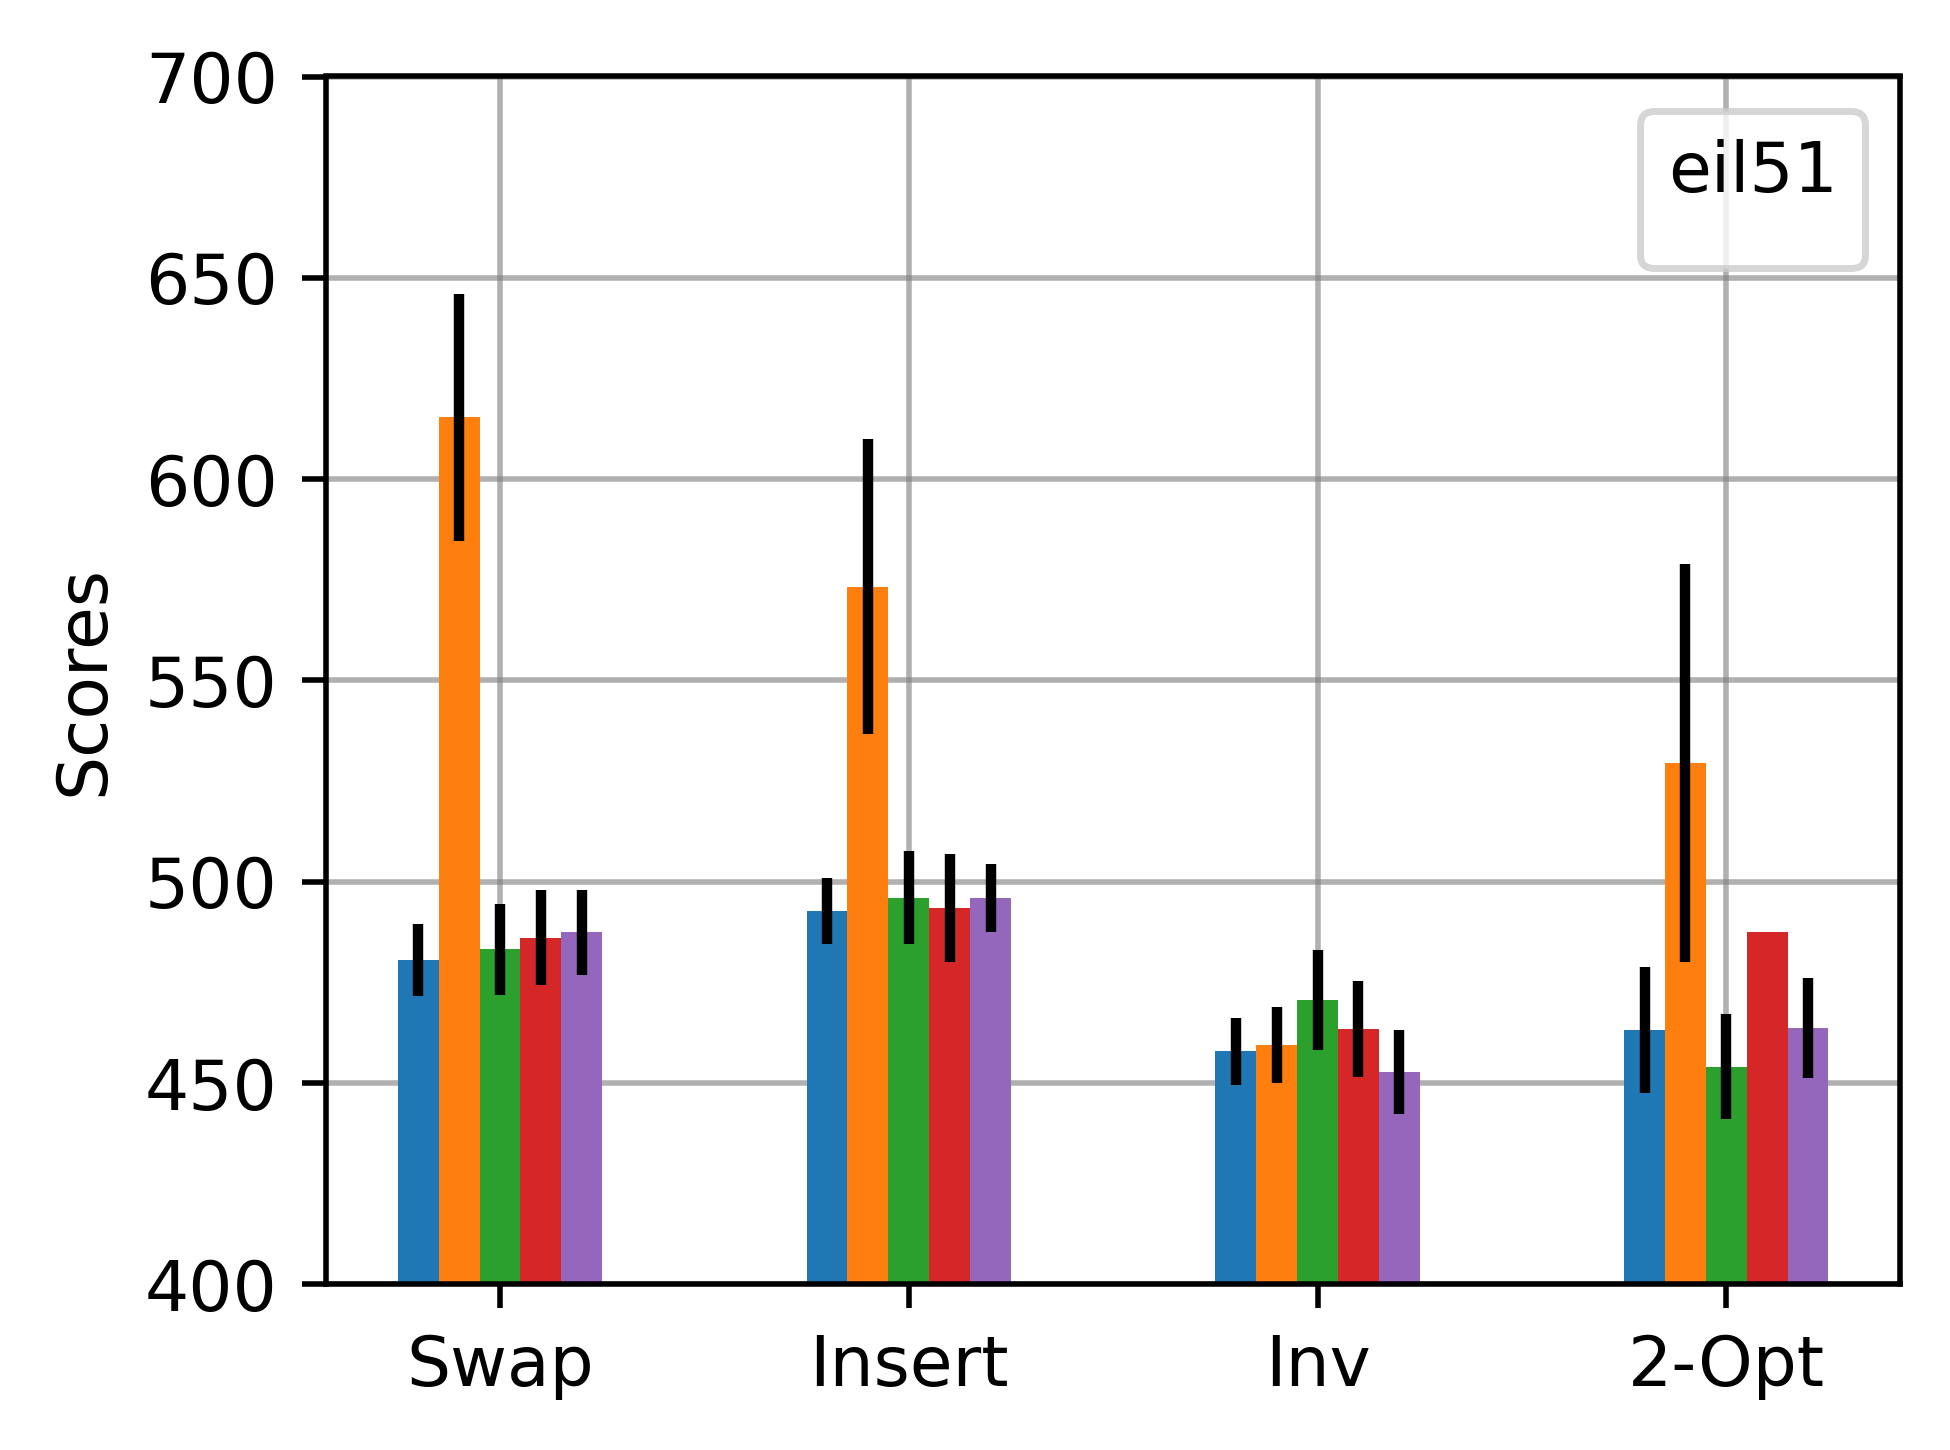

In [27]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2, align='center', alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-', zorder=0, alpha=0.618)
plt.ylim([400, 700])

plt.legend(title='eil51', loc='upper right')

plt.tight_layout()
plt.savefig('tuning_51_greedy.png')
plt.show()

In [28]:
N_runs = 20
file = 'a280'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=True, fileID=fileID)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


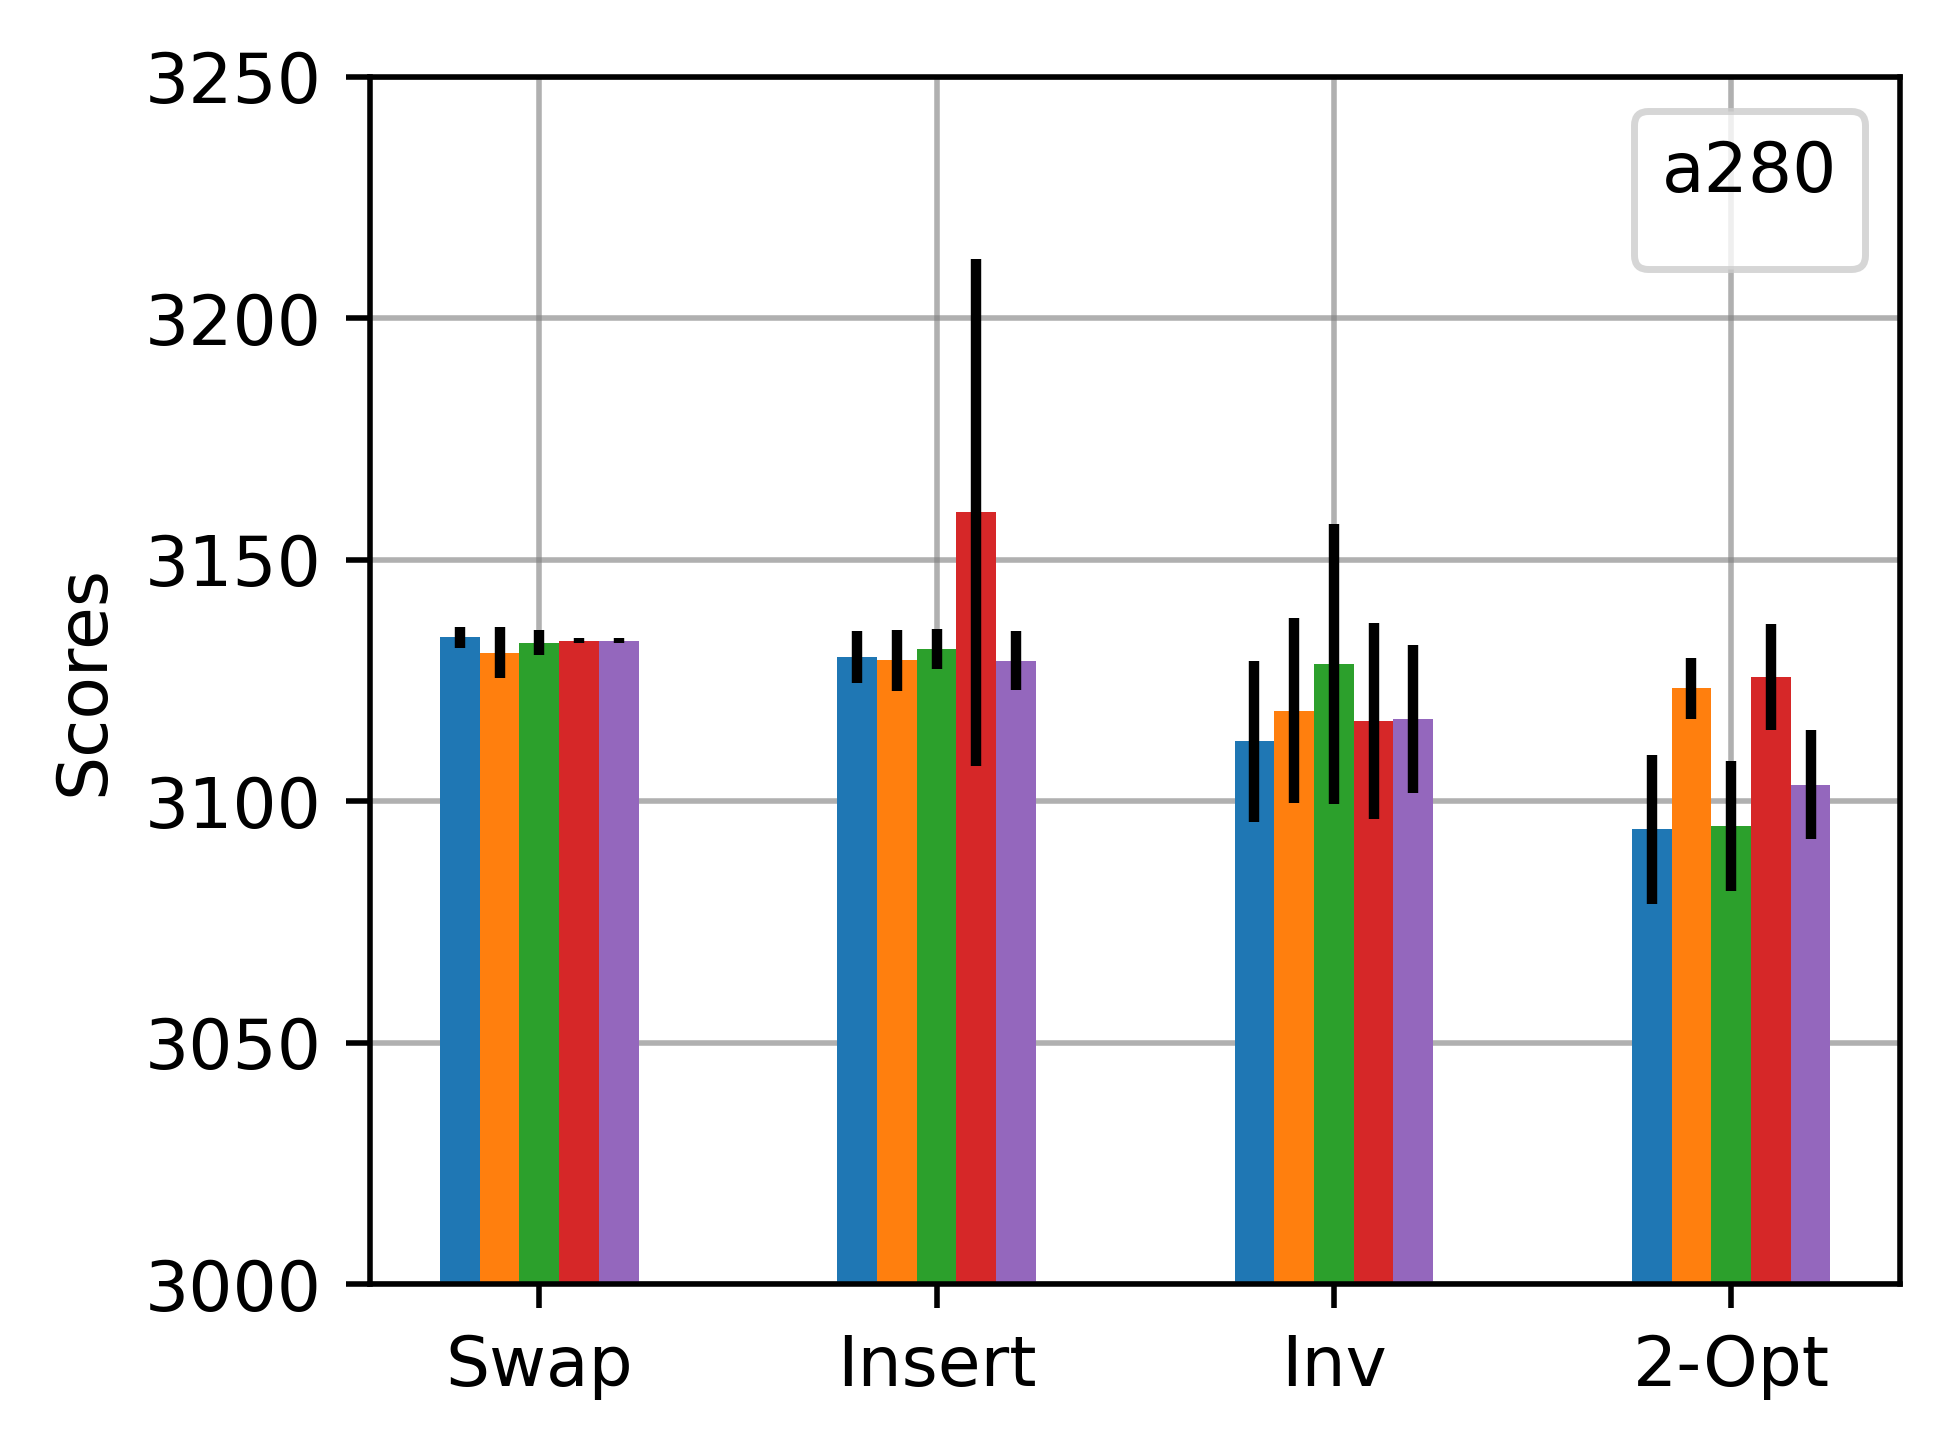

In [29]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2, align='center', alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-', zorder=0, alpha=0.618)
plt.ylim([3000, 3250])

plt.legend(title='a280', loc='upper right')

plt.tight_layout()
plt.savefig('tuning_280_greedy.png')
plt.show()

In [30]:
N_runs = 20
file = 'pcb442'
file_path = f'TSP-Configurations/{file}.tsp.txt'
tsp_data = load_tsp_file(file_path)
distance_matrix = calculate_distance_matrix(tsp_data)

iterations_list = [10000]
results = compare_all_algorithms(tsp_data, distance_matrix, file, N_runs, iterations_list, plot_results=False, greedy=True, fileID=fileID)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)
C:\Users\jaspe\AppData\Local\Temp\ipykernel_3876\1115880721.py:35: RuntimeWarning: overflow encountered in double_scalars
  return new_score < current_score or np.random.rand() < np.exp((current_score - new_score) / T)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


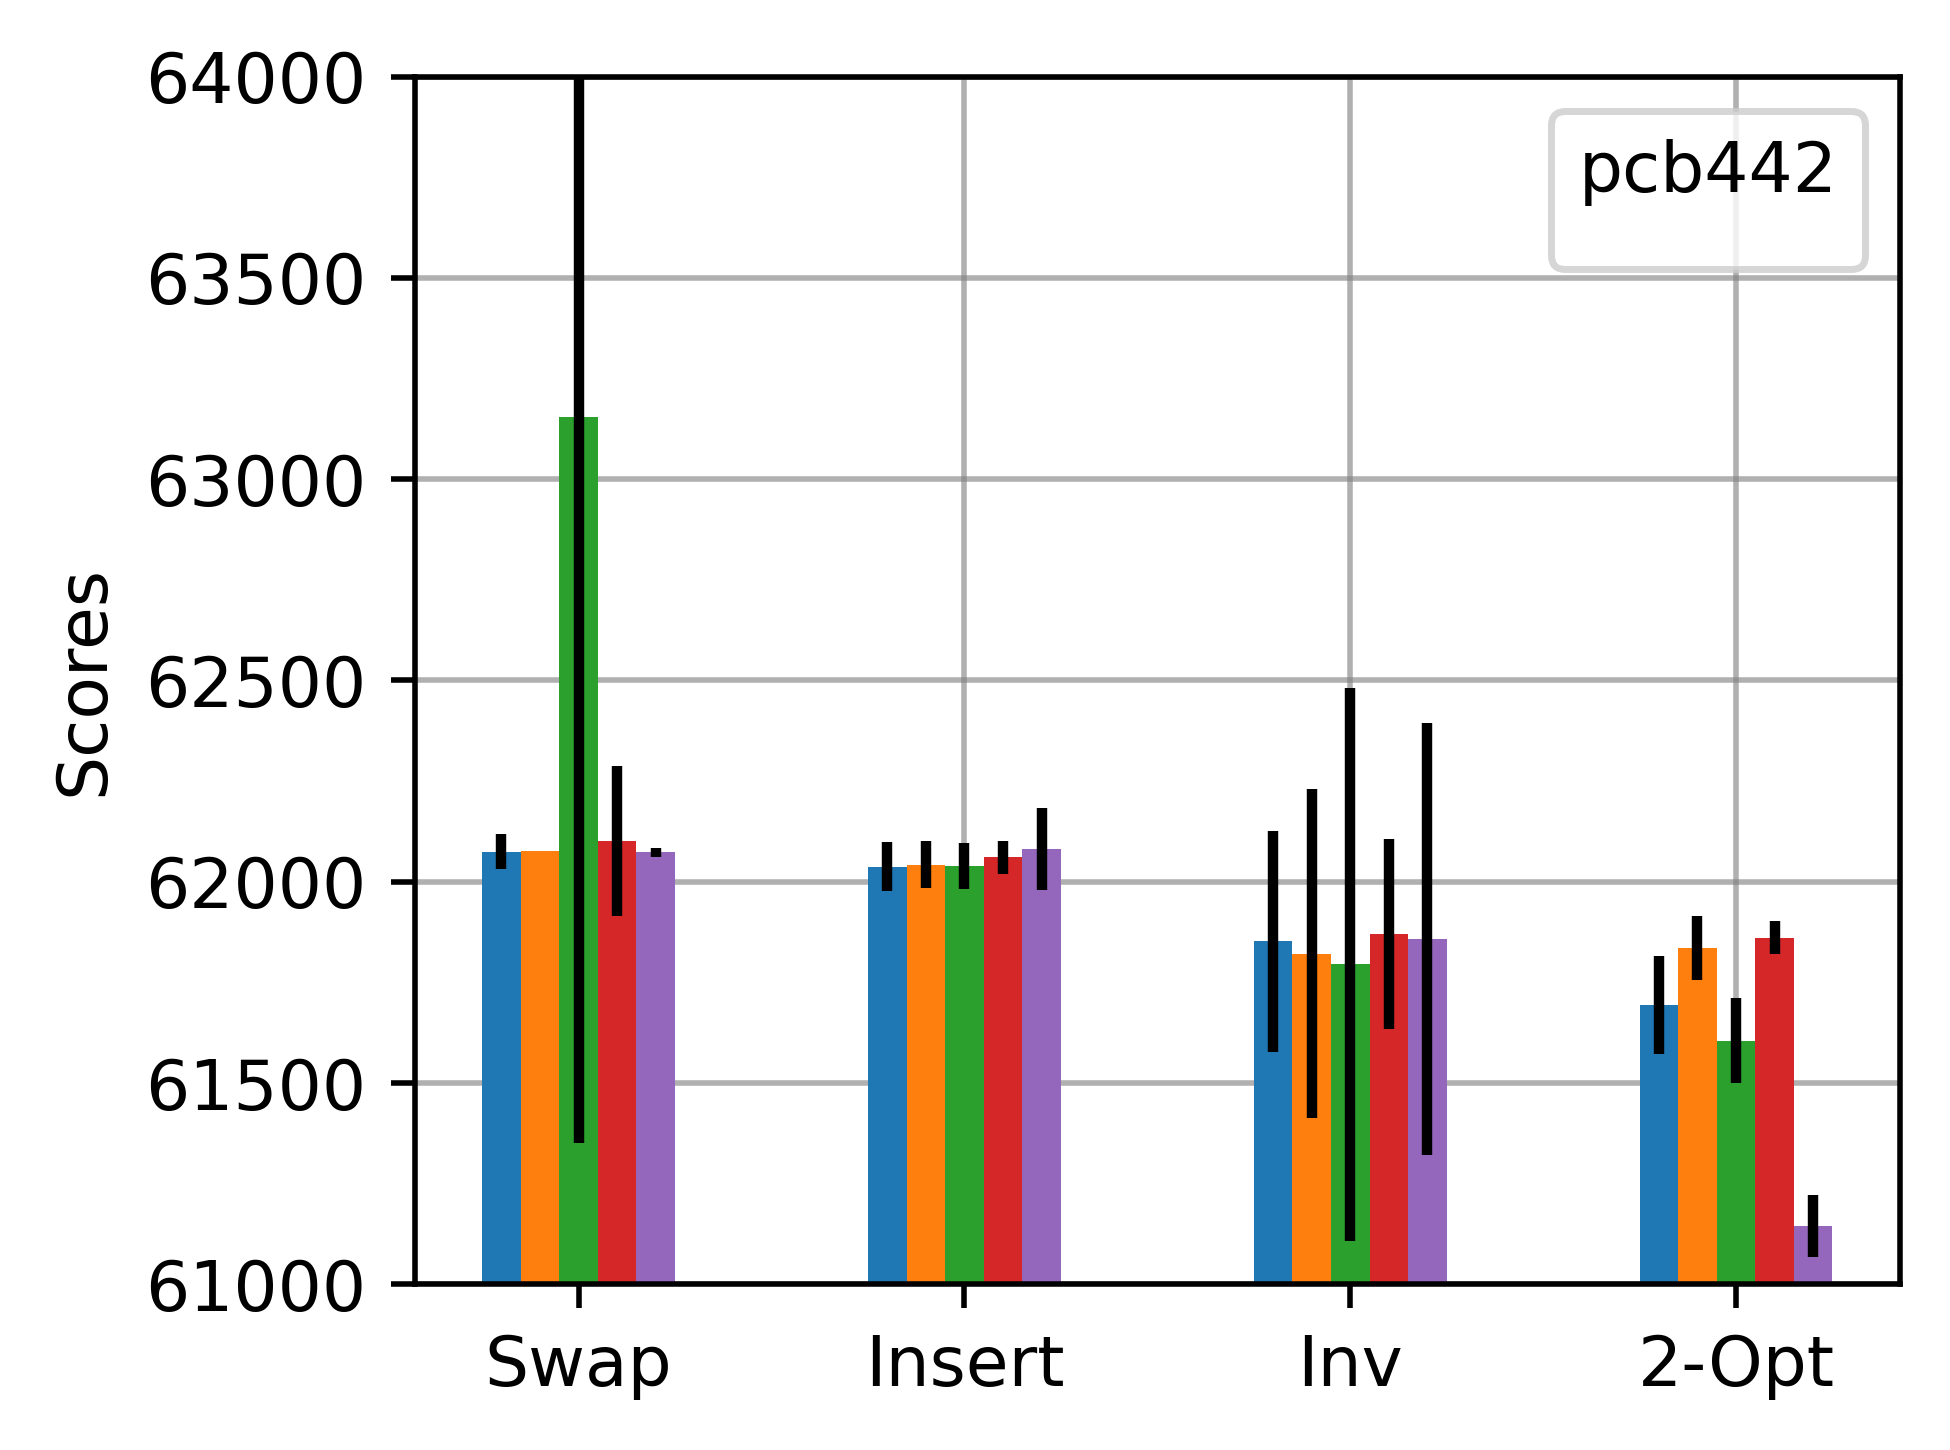

In [31]:
plt.figure(figsize=(4, 3), dpi=500)

bar_width = 0.1
bar_positions = np.arange(len(mutations))
mutation_names = [func.__name__.title() for func in mutations]
mutation_names[2] = 'inv'.title()
mutation_names[3] = '2-Opt'
cooling_schemes = ['Simulated Annealing with Logarithmic Cooling', 'Simulated Annealing with Linear Cooling', 'Simulated Annealing with Arithmetic-Geometrical Cooling','Simulated Annealing with Exponential Cooling', 'Simulated Annealing with Quadratic Cooling']

res = results[0]
for i, sched in enumerate(res):
    bar_results = []
    bar_stds = []

    for data in sched['data']:
        average = data['average']
        std = data['std']
        bar_results.append(average)
        bar_stds.append(std)

    plt.bar(bar_positions + i * bar_width, bar_results, yerr=bar_stds, width=bar_width, zorder=2, align='center', alpha=1)

plt.ylabel('Scores')
plt.xticks(bar_positions + bar_width * (len(cooling_schemes) - 1) / 2, mutation_names)
plt.grid(color='gray', linestyle='-', zorder=0, alpha=0.618)
plt.ylim([61000, 64000])

plt.legend(title='pcb442', loc='upper right')

plt.tight_layout()
plt.savefig('tuning_442_greedy.png')
plt.show()

In [32]:
N_runs = 20
file='eil51'
fileID = 'random_'

mutate = inversion
cooling_schedule = arithmetic_geometric_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

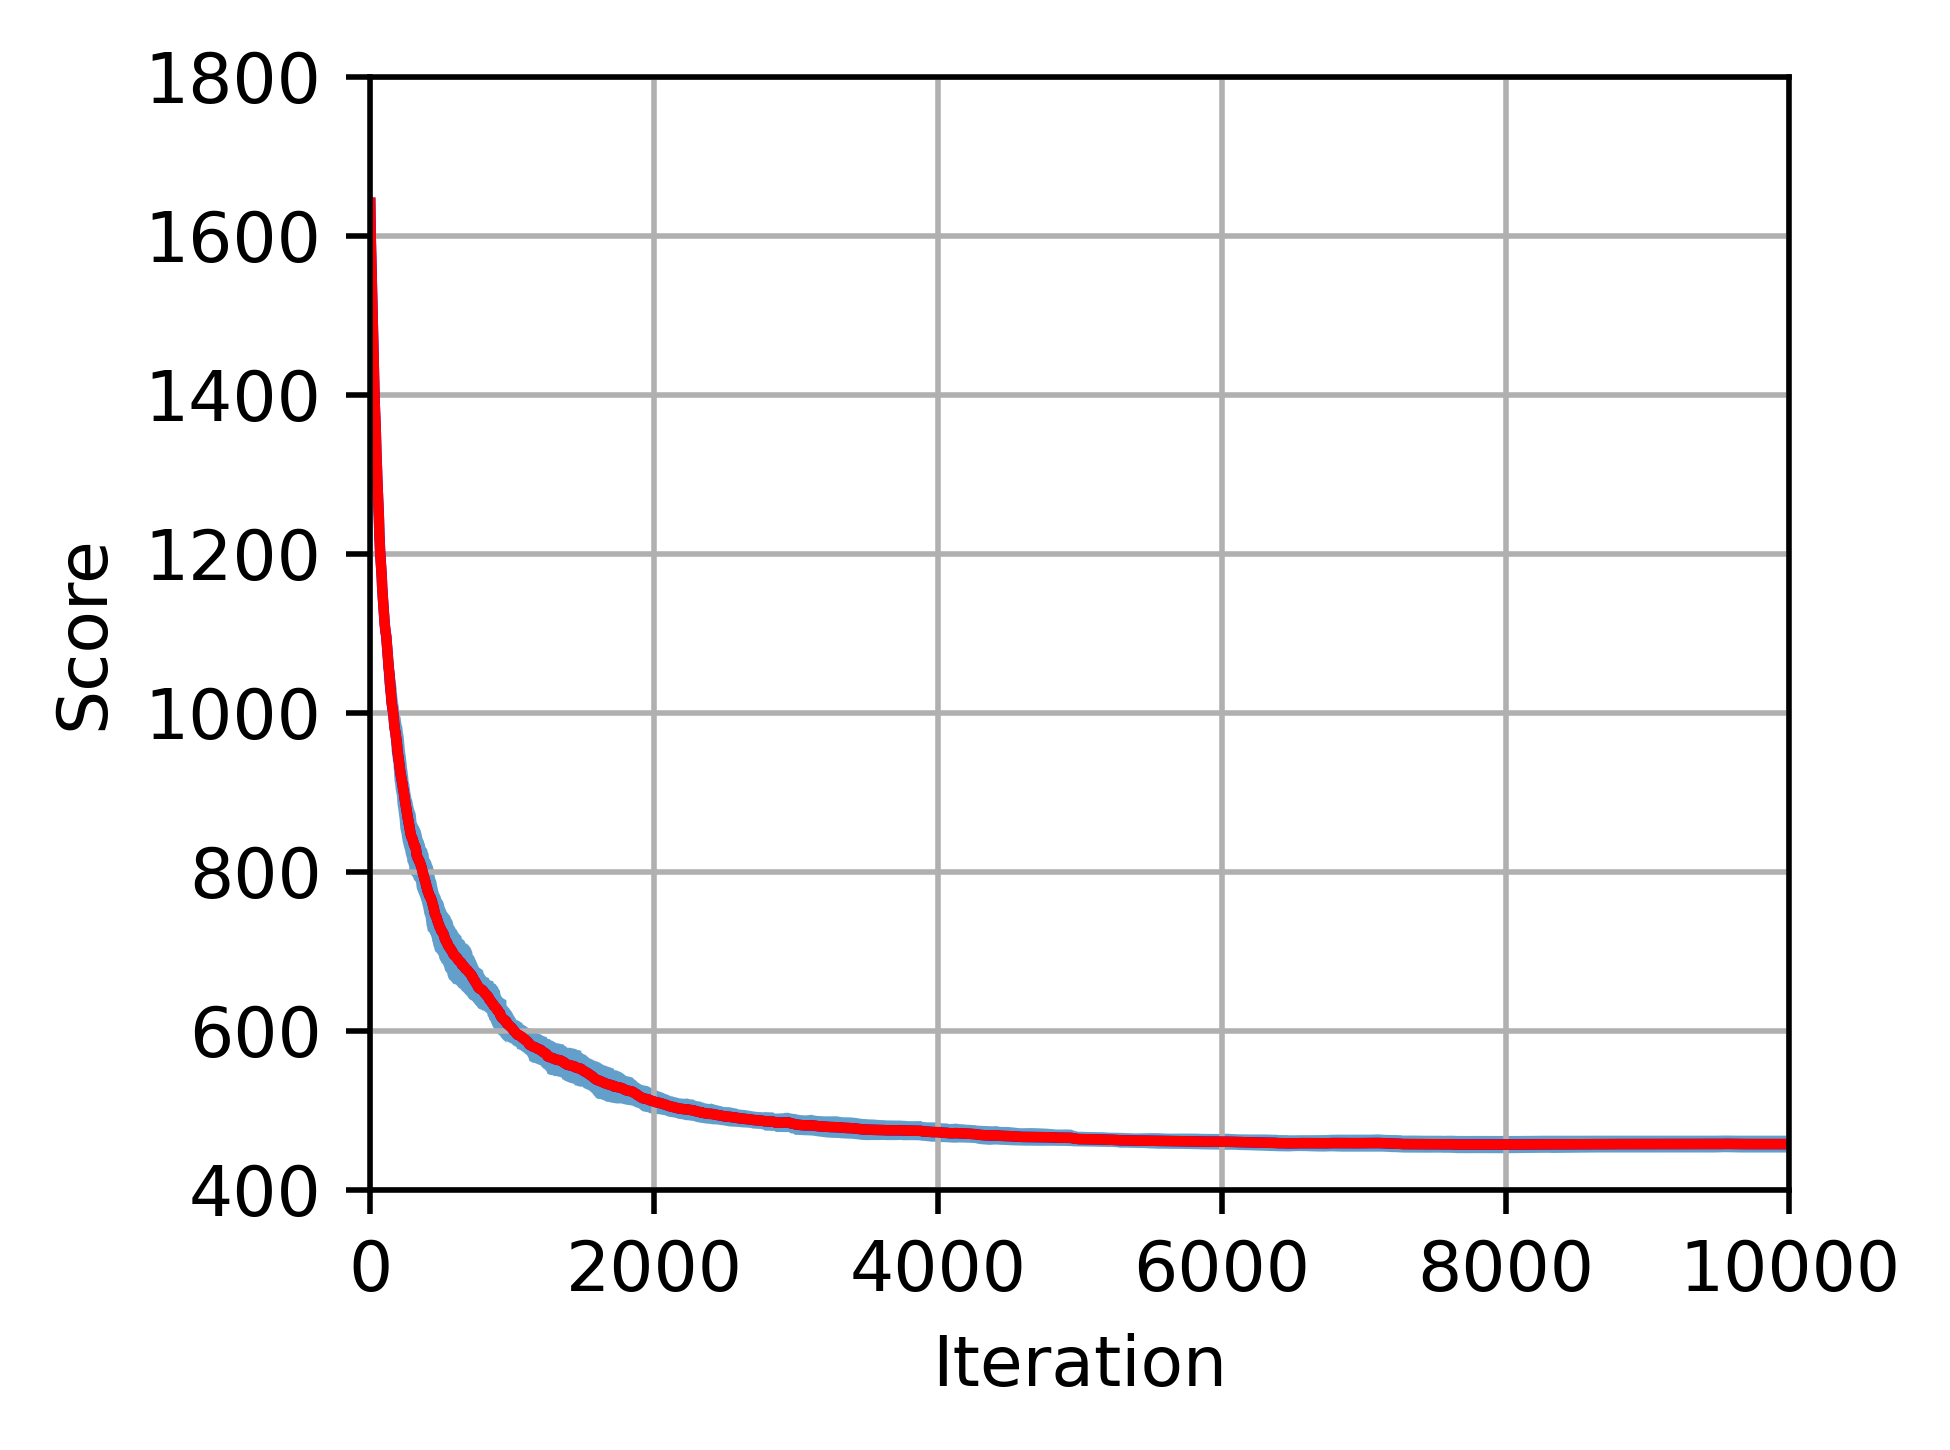

In [33]:
# Plot
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.ylim([400, 1800])
plt.grid()
plt.tight_layout()

plt.savefig('score_51_random.png')
plt.show()


In [35]:
N_runs = 10
file='a280'
fileID = 'random_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

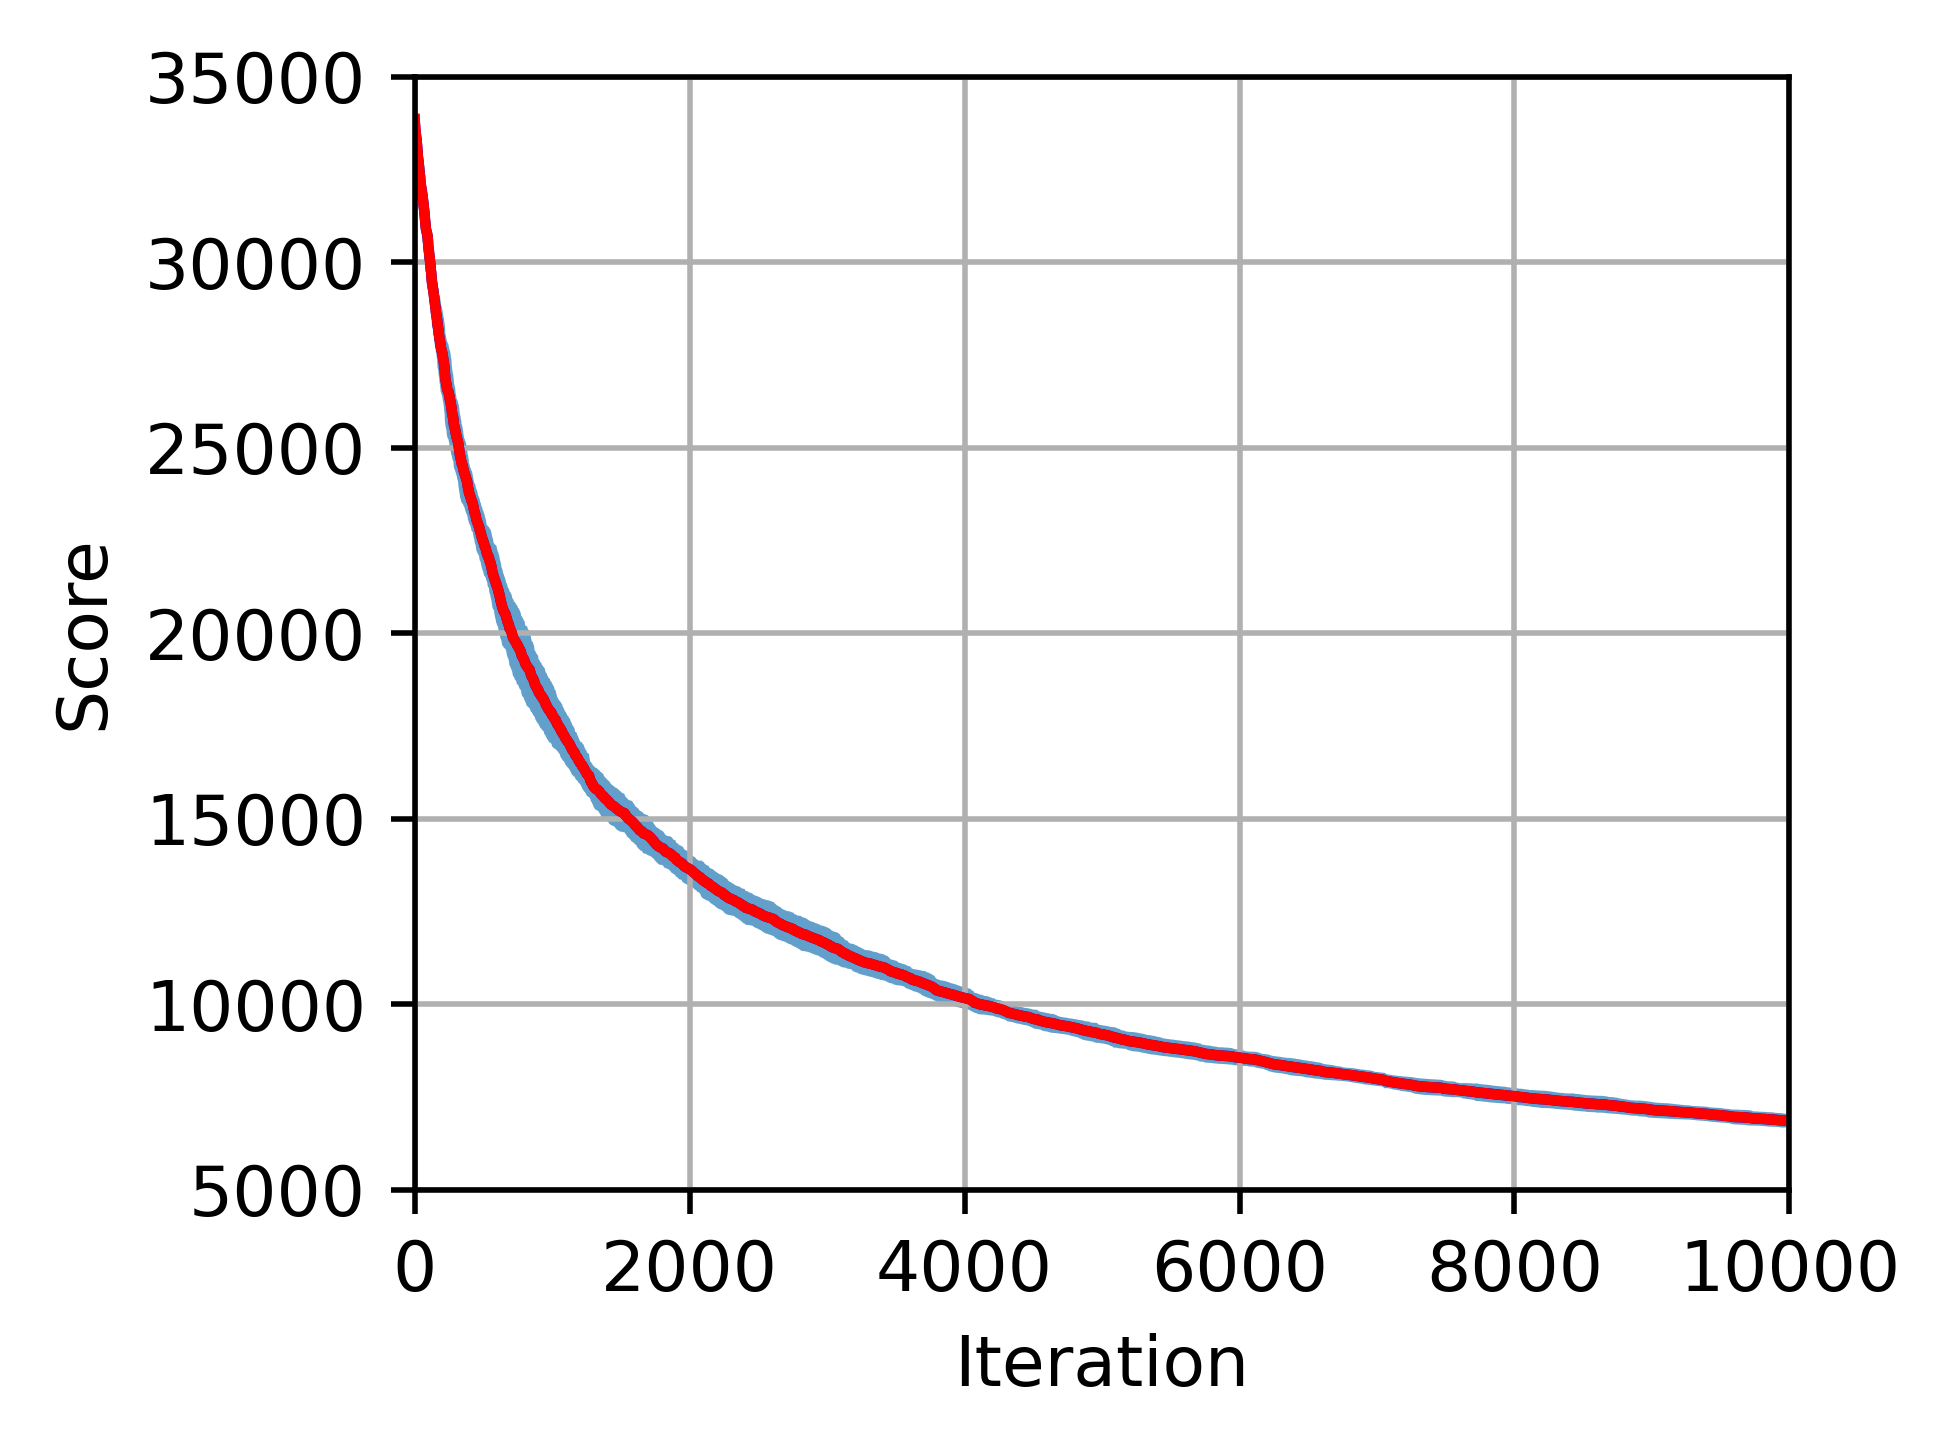

In [39]:
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.ylim([5000, 35000])
plt.grid()
plt.tight_layout()

plt.savefig('score_280_random.png')
plt.show()

In [41]:
N_runs = 10
file='pcb442'
fileID = 'random_'

mutate = inversion
cooling_schedule = quadratic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std)

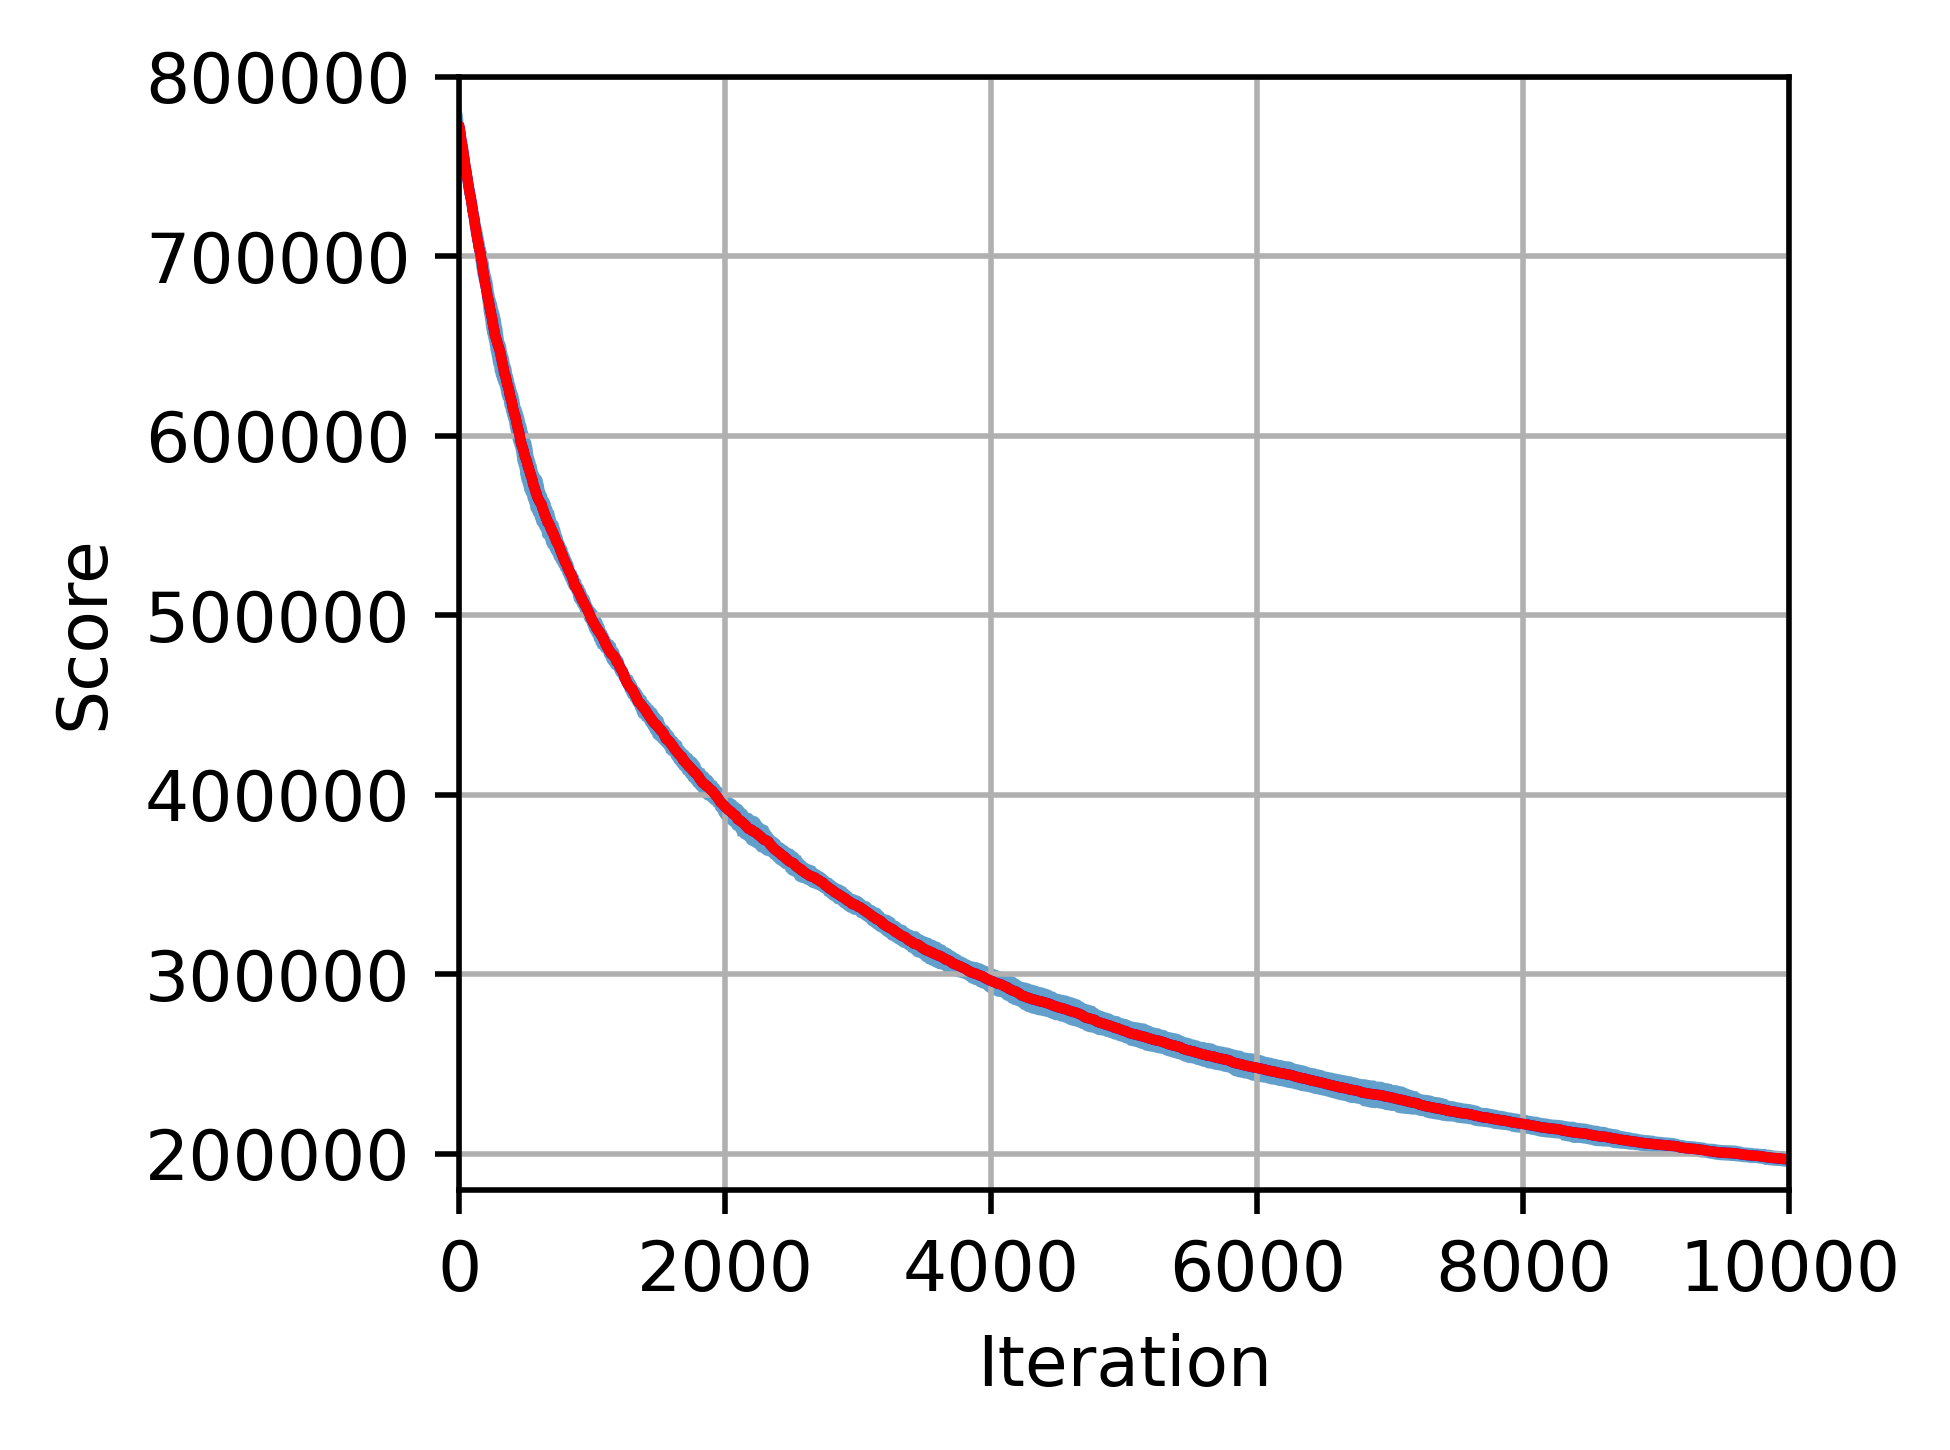

In [42]:
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.ylim([180000, 800000])
plt.grid()
plt.tight_layout()

plt.savefig('score_442_random.png')
plt.show()

Now let's do the same for greedy

In [44]:
N_runs = 10
file='eil51'
fileID = 'greedy_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 5000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

In [46]:
N_runs = 20
file='eil51'
fileID = 'greedy_'

mutate = inversion
cooling_schedule = logarithmic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errors = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

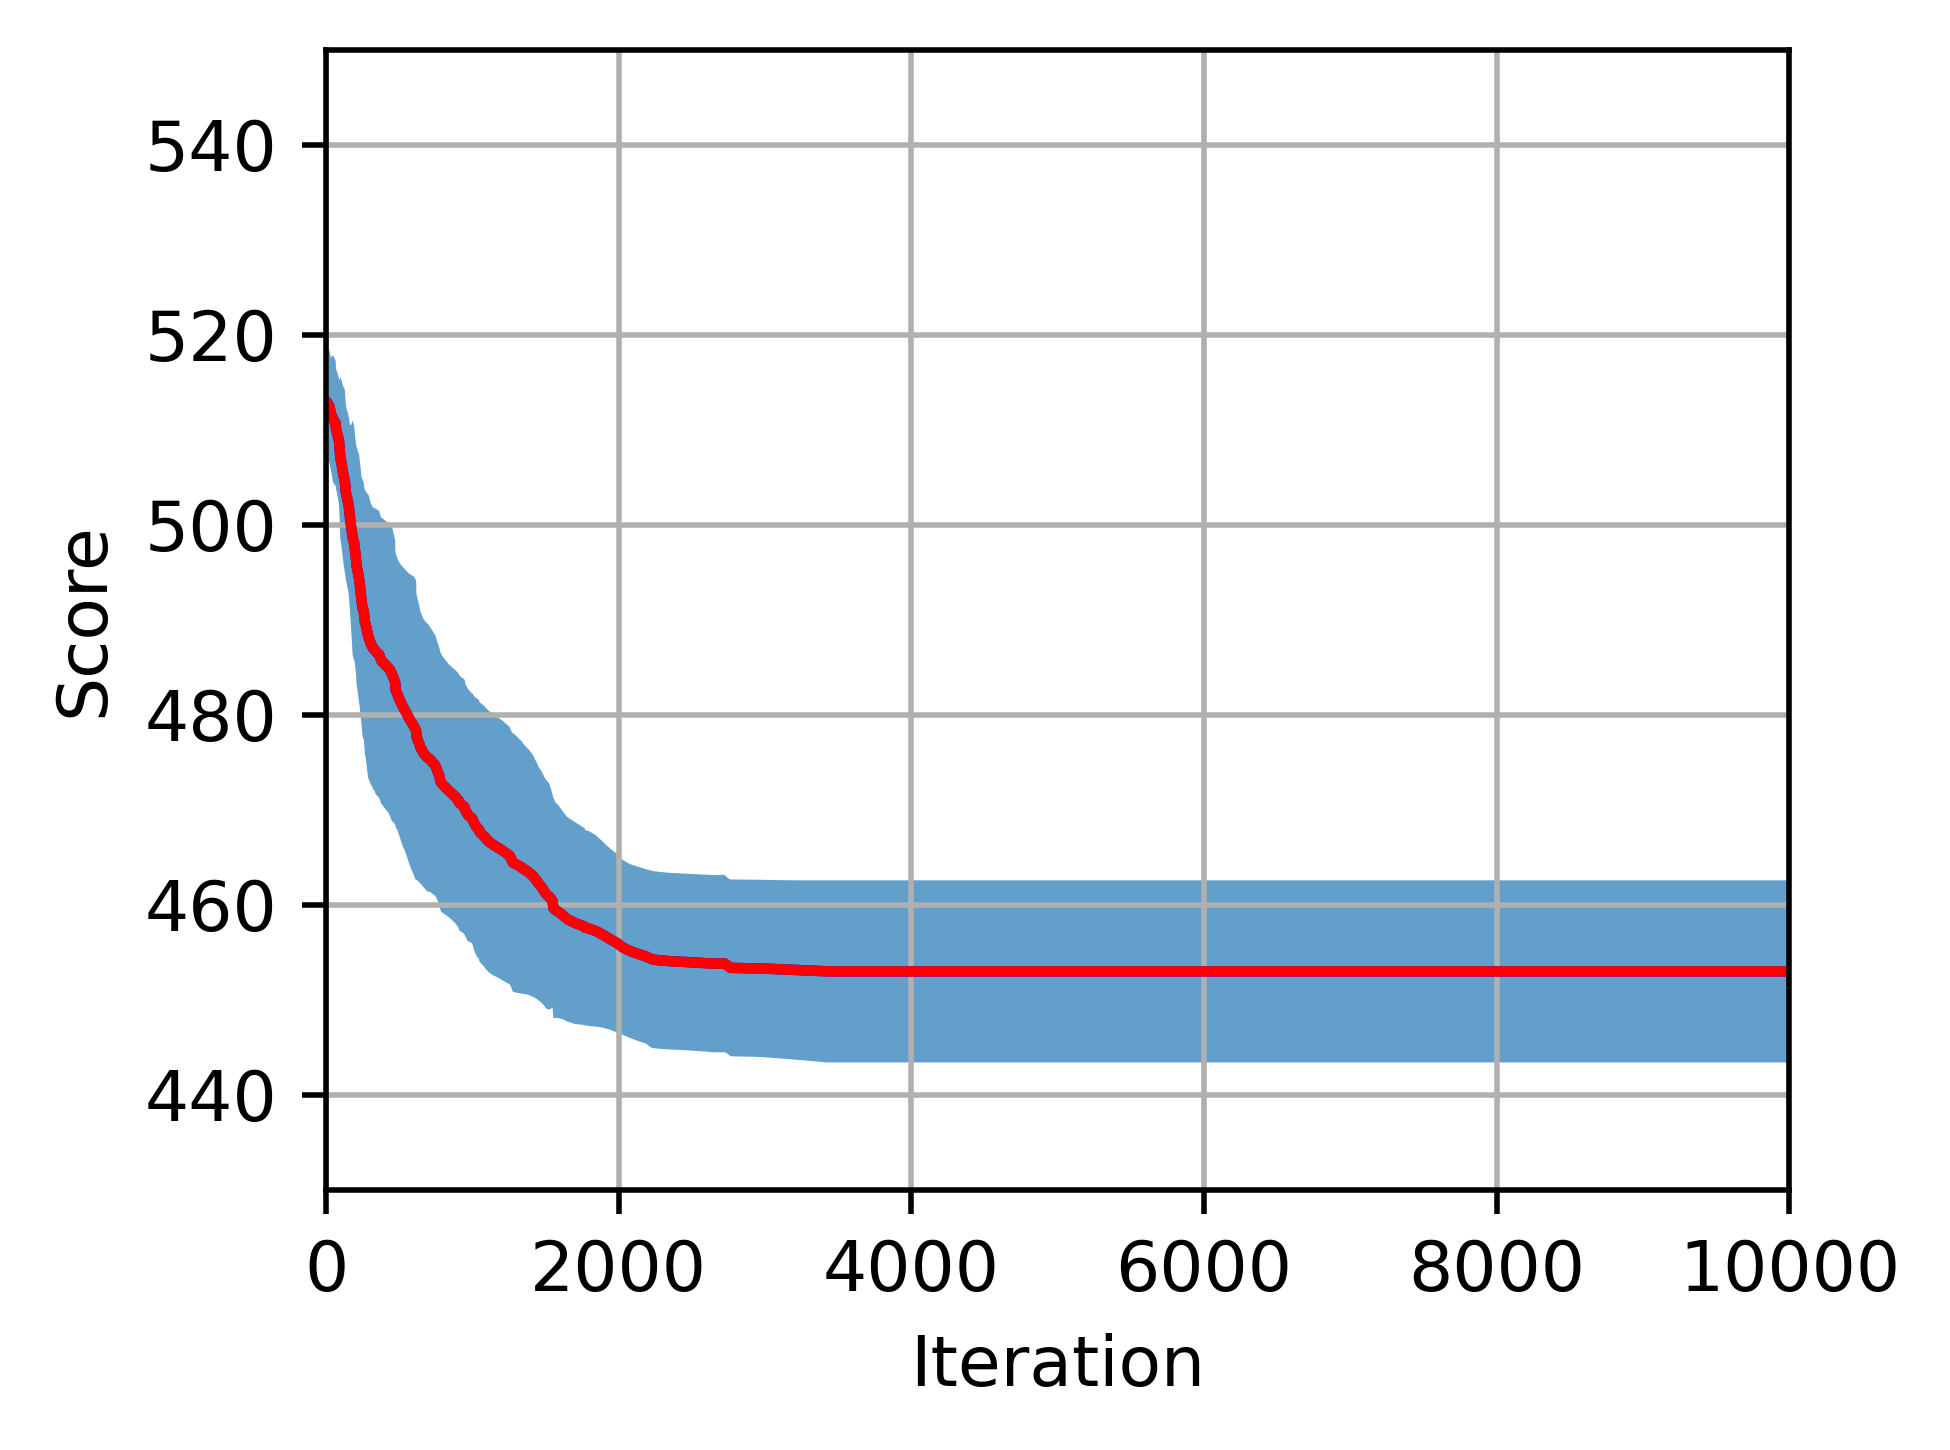

In [47]:
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.ylim([430, 550])
plt.grid()
plt.tight_layout()

plt.savefig('score_51_greedy.png')
plt.show()

In [49]:
N_runs = 20
file='a280'
fileID = 'greedy_'

mutate = two_opt
cooling_schedule = arithmetic_geometric_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores,errores = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

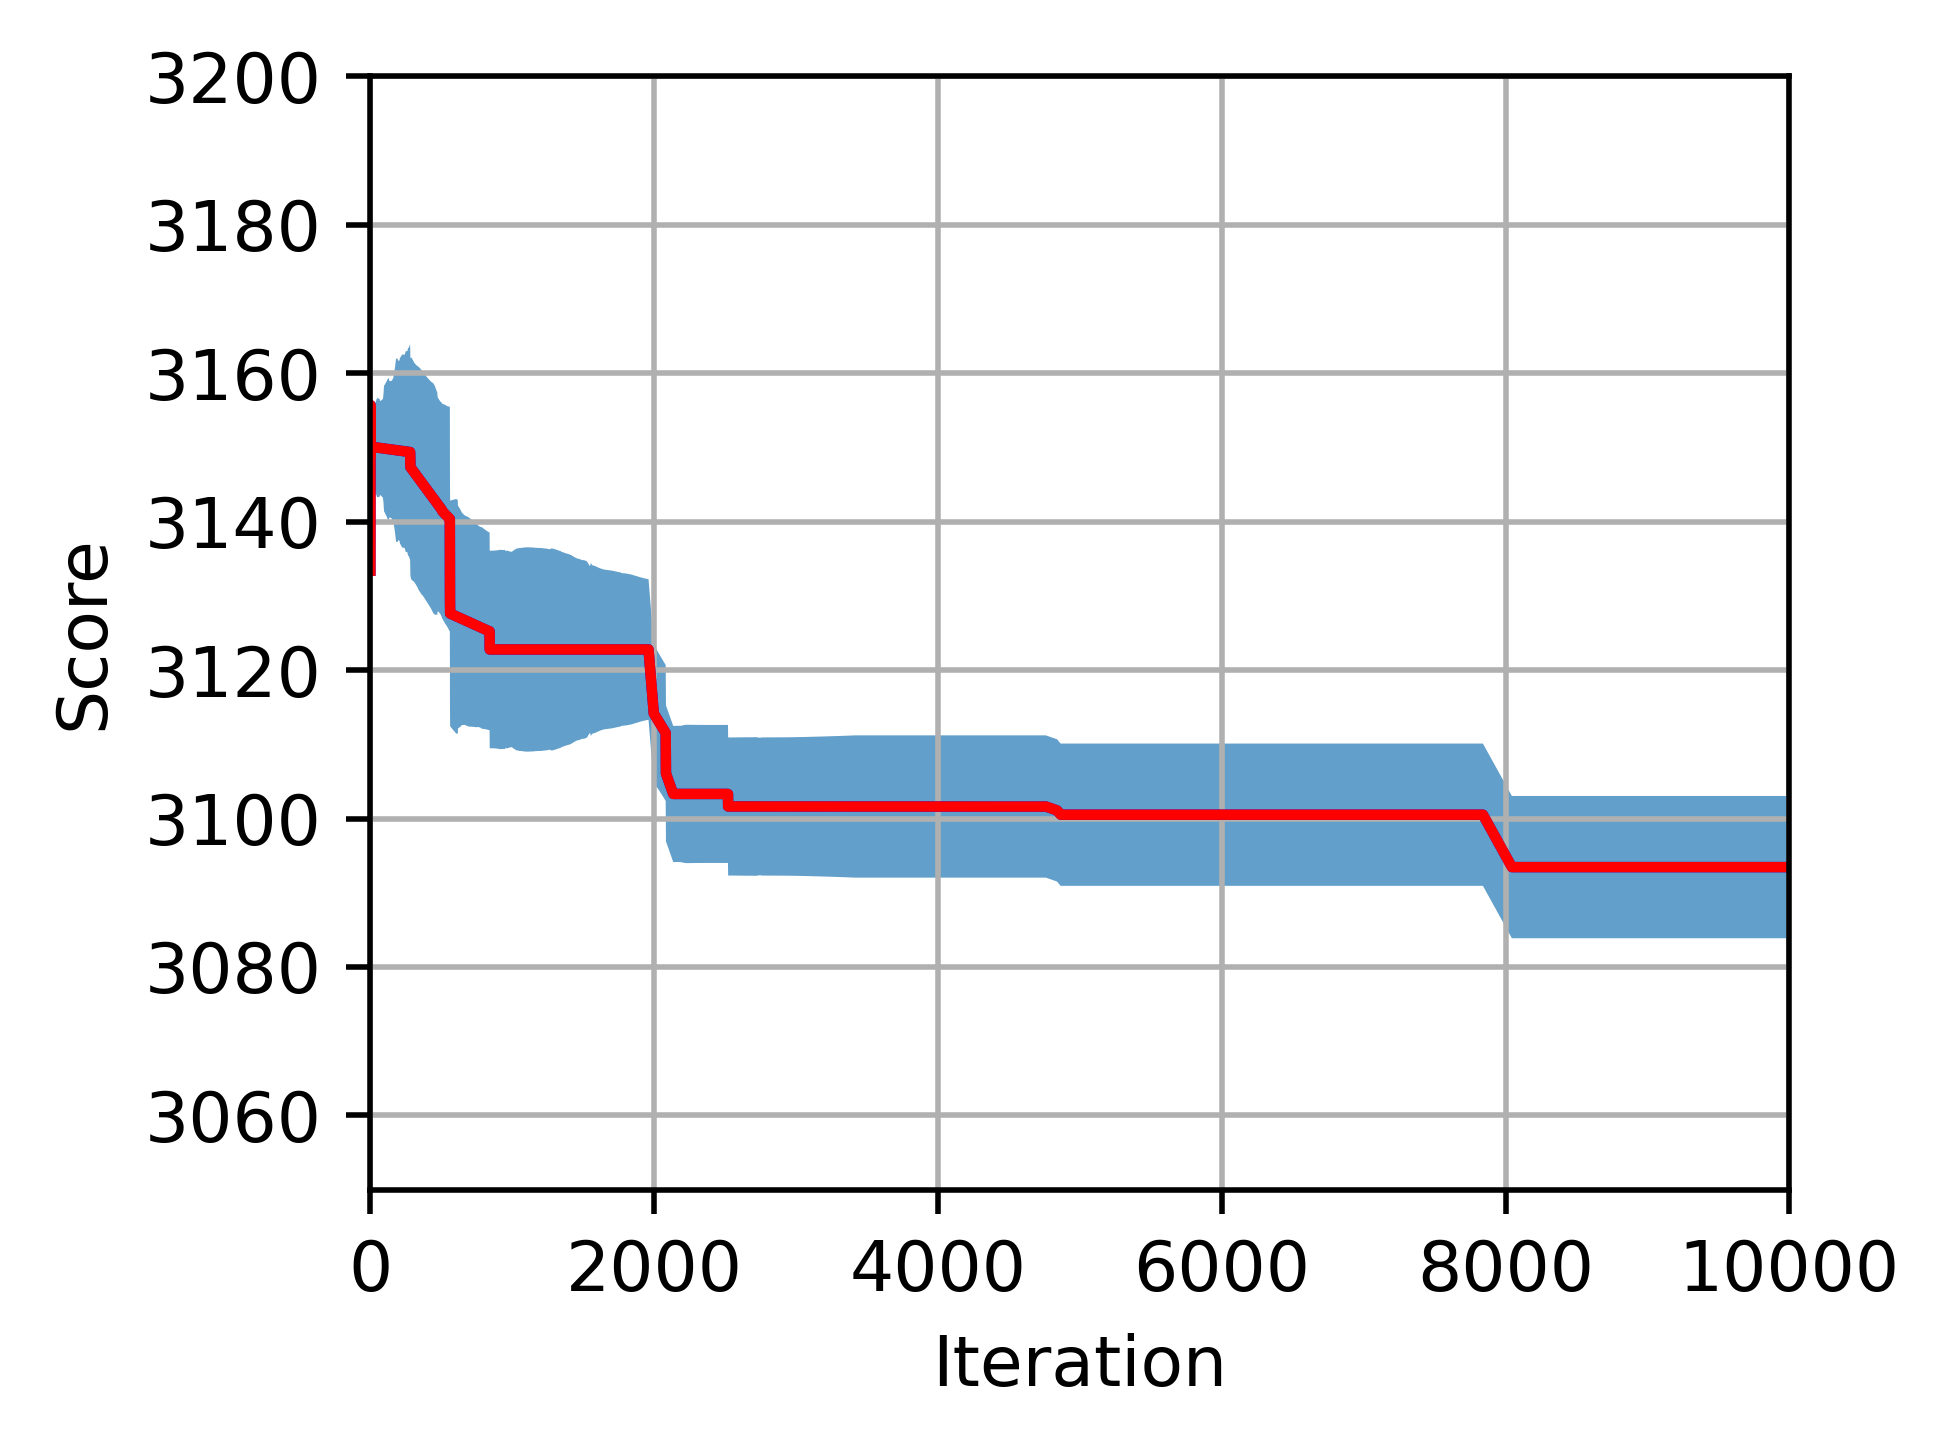

In [50]:
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.ylim([3050, 3200])
plt.grid()
plt.tight_layout()

plt.savefig('score_280_greedy.png')
plt.show()

In [52]:
N_runs = 20
file='pcb442'
fileID = 'greedy_'

mutate = two_opt
cooling_schedule = quadratic_cool

iterations = 10000

# Set this to the desired STD to stop the simulation with a maximum of N_runs runs, or set it to a negative value to just do N_runs runs
desired_std=-1

scores, errores = investigate_performance(file, mutate, cooling_schedule, iterations, fileID, N_runs, desired_std=desired_std, greedy=True)

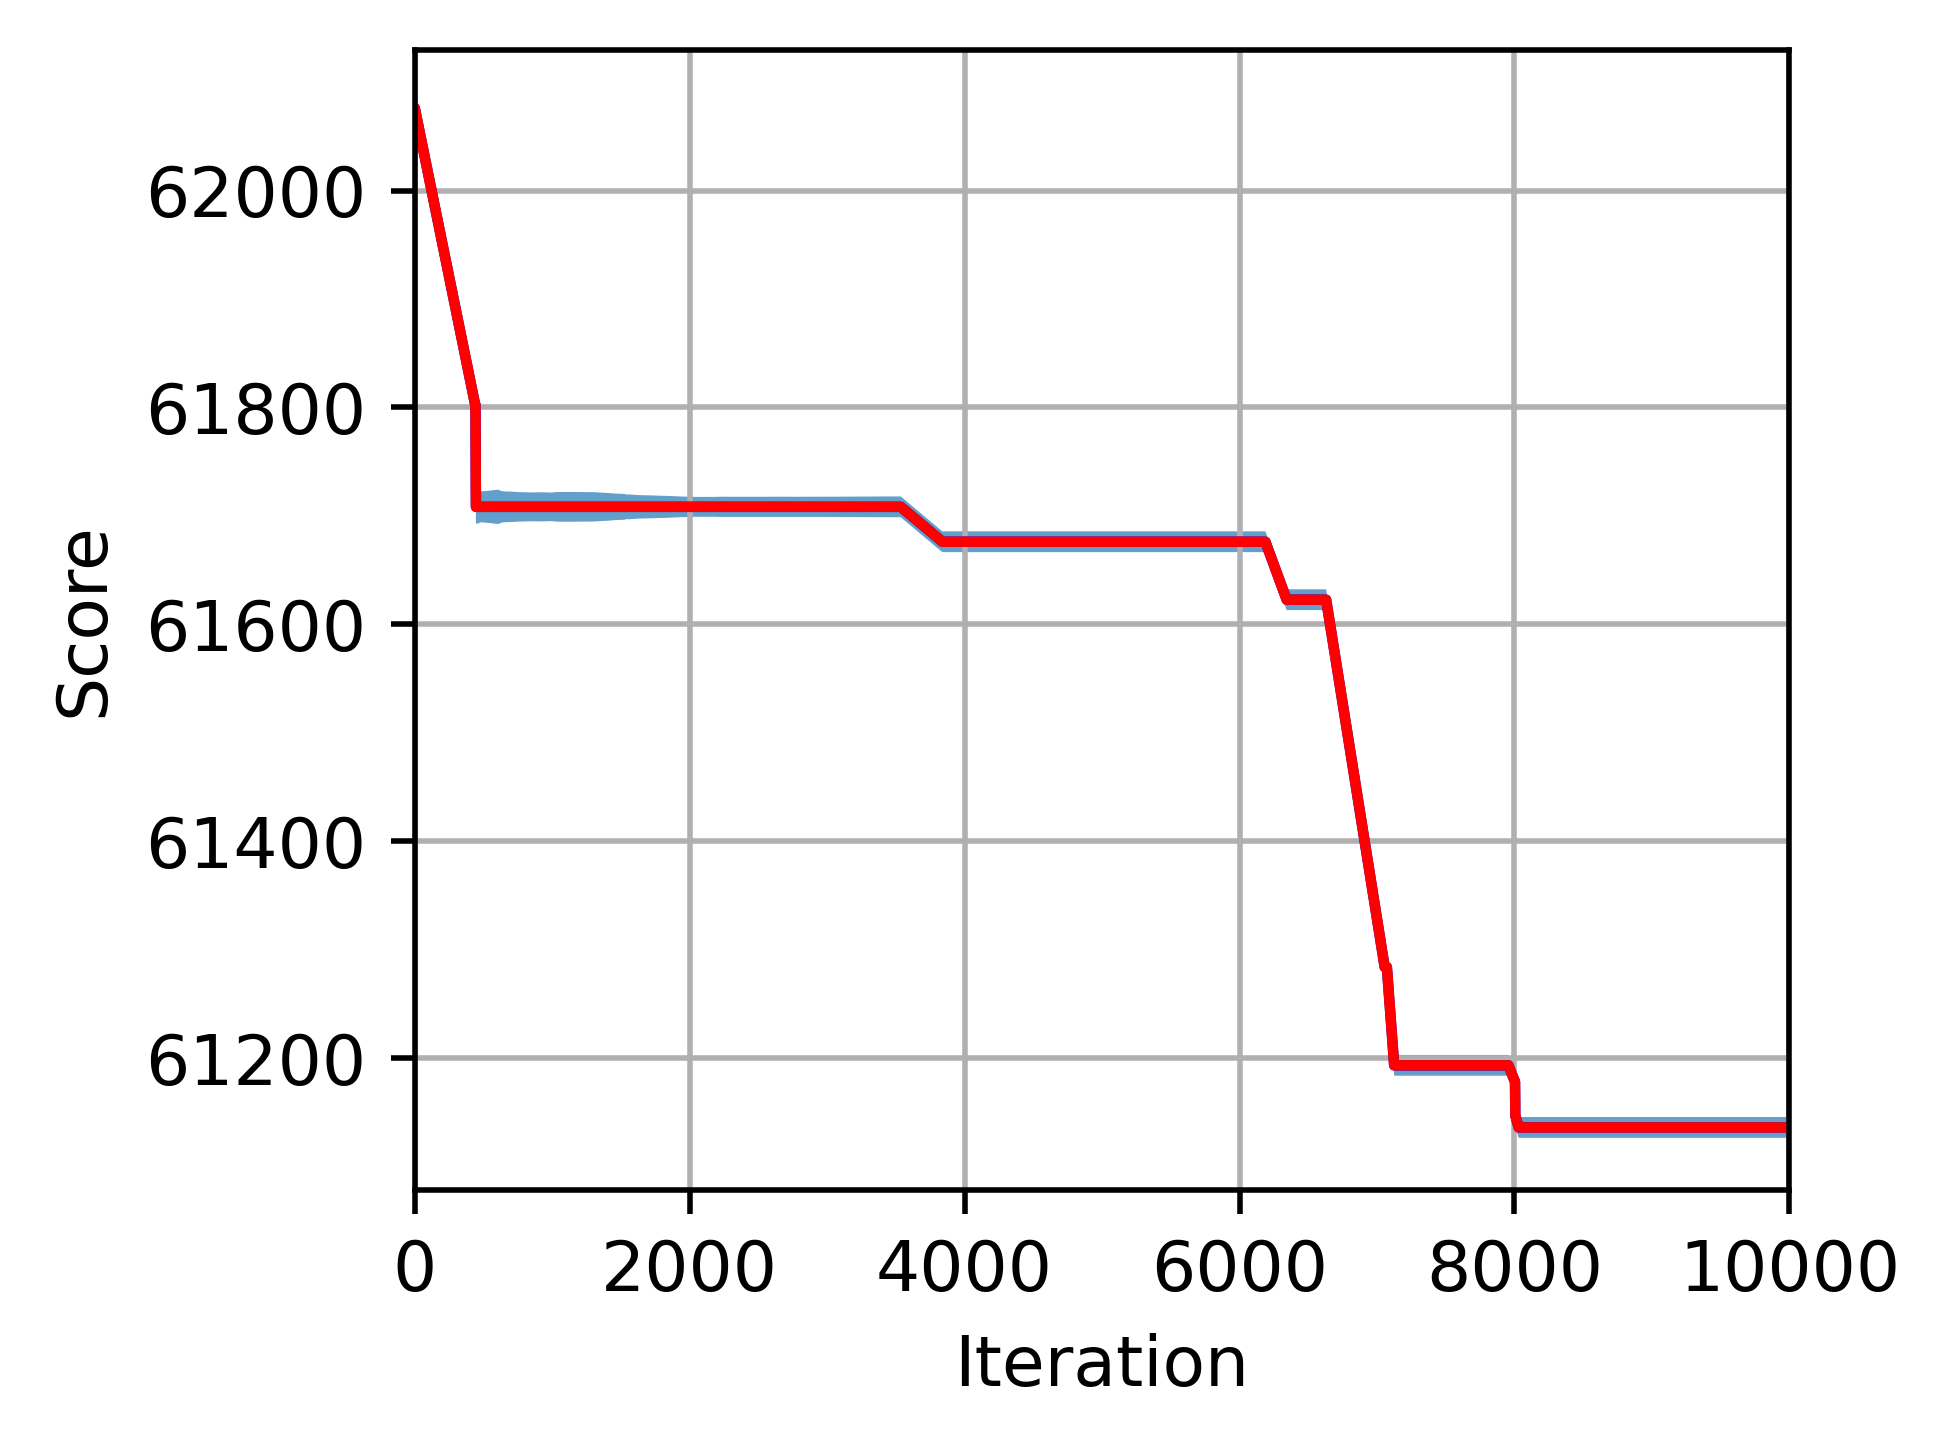

In [53]:
plt.figure(figsize=(4, 3), dpi=500)

plt.plot(np.arange(iterations), scores, linestyle='-', color='b')
plt.fill_between(np.arange(iterations), scores - errors, scores + errors, alpha=0.7)
plt.plot(np.arange(iterations), scores, linestyle='-', color='r')

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.xlim([0, 10000])
plt.grid()
plt.tight_layout()

plt.savefig('score_442_greedy.png')
plt.show()